In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [3]:
from statsmodels.tsa.api import SimpleExpSmoothing

In [4]:
nflx_data = pd.read_csv('./NFLX.csv', index_col='Date')

In [5]:
nflx_data.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-04-11  350.000000  354.779999  345.200012  348.000000  348.000000   
2022-04-12  355.910004  359.410004  342.250000  344.100006  344.100006   
2022-04-13  343.920013  352.000000  341.160004  350.429993  350.429993   
2022-04-14  350.950012  352.000000  339.859985  341.130005  341.130005   
2022-04-18  340.000000  342.359985  331.619995  337.859985  337.859985   

             Volume  
Date                 
2022-04-11  3777100  
2022-04-12  3824300  
2022-04-13  3231000  
2022-04-14  4343800  
2022-04-18  5105000

In [6]:
def plot_init_graph (data, features = ['Close'], interval=60):
    plt.figure(figsize=(15,10))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in data.index.values]
    for f in features:
        plt.plot(x_dates, data[f], label=f)
    plt.xticks(rotation=90)
    plt.xlabel('Time Scale')
    plt.ylabel('scaled USD')
    plt.legend()
    plt.show()

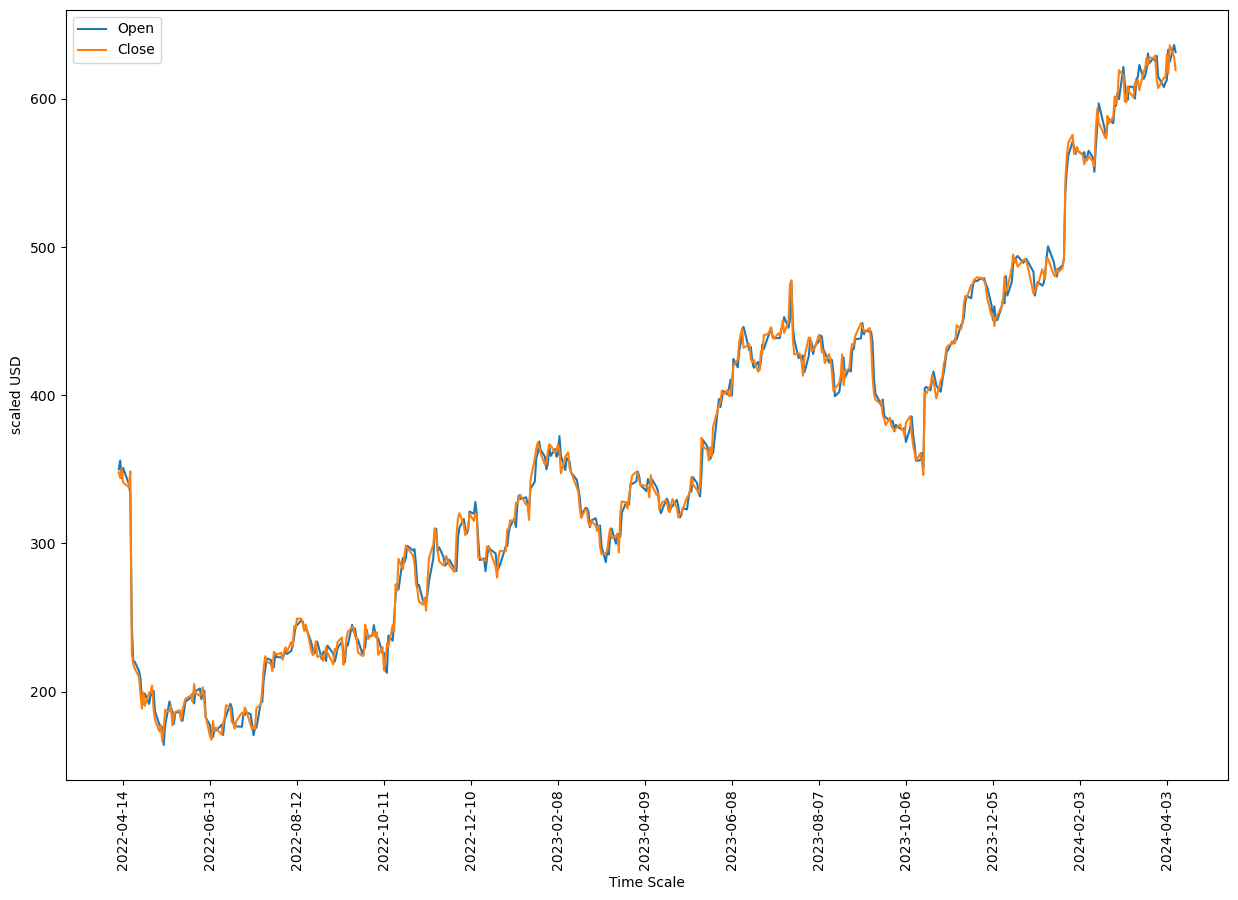

In [7]:
plot_init_graph (nflx_data, features = ['Open', 'Close'])

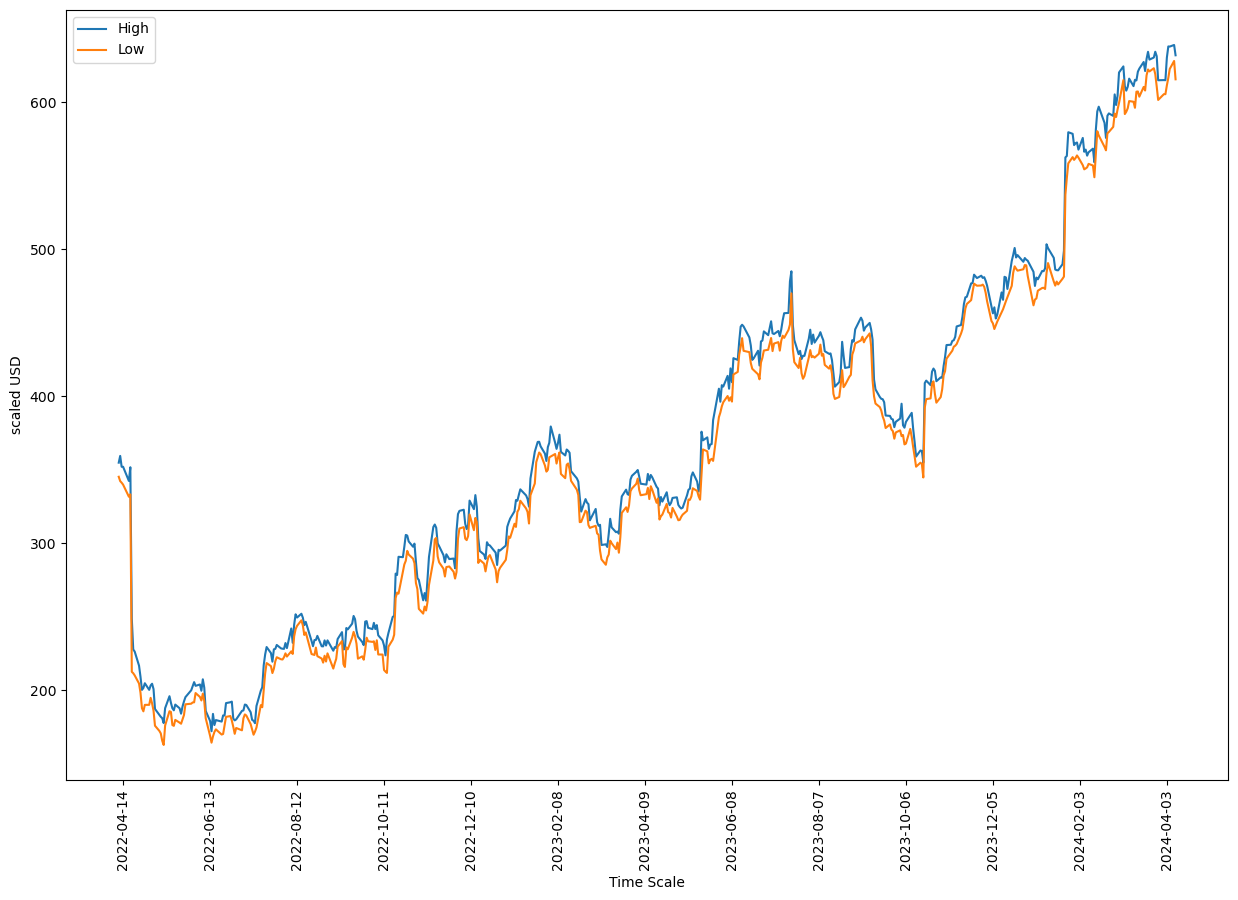

In [8]:
plot_init_graph (nflx_data, features = ['High', 'Low'])

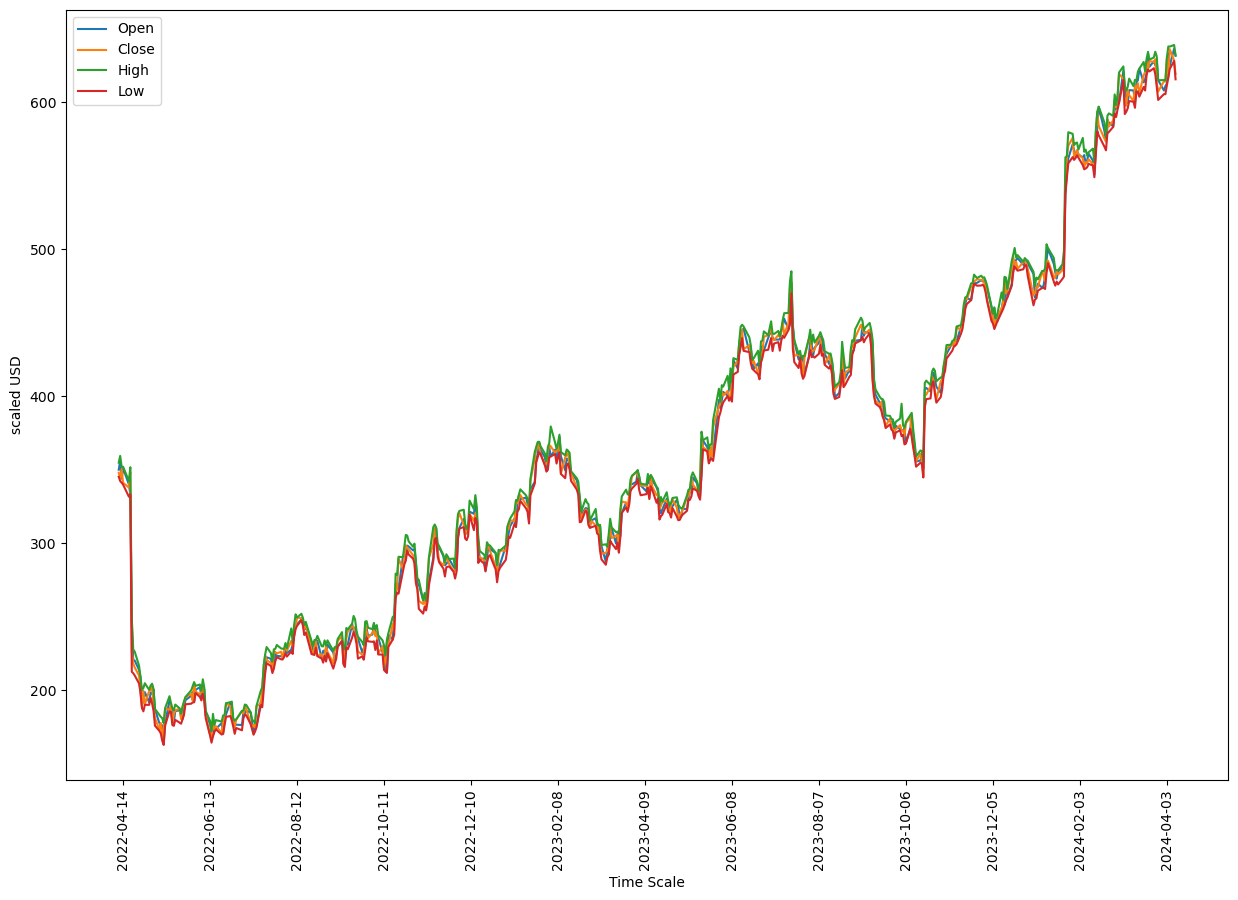

In [9]:
plot_init_graph (nflx_data, features = ['Open', 'Close', 'High', 'Low'])

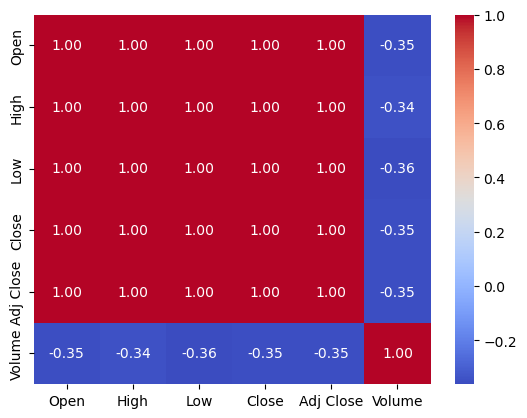

In [10]:
ntflx_correlation_matrix = nflx_data.corr()
sns.heatmap(ntflx_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [11]:
def lstm_split(data, n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps+1):
        X.append(data[i:i + n_steps, :-1])
        y.append(data[i + n_steps-1, -1])
    
    return np.array(X), np.array(y)

In [12]:
def get_train_test_data (data, n_steps=2, train_split=0.8):
    target_y = nflx_data['Close']
    X_feat = nflx_data.iloc[:,0:3]
    
    sc = StandardScaler()
    X_ft = sc.fit_transform(X_feat.values)
    X_ft = pd.DataFrame(columns=X_feat.columns, data=X_ft, index=X_feat.index)
    # print(X_ft.head())
    
    X1, y1 = lstm_split(X_ft.values, n_steps=n_steps)
    train_split=train_split
    split_idx = int(np.ceil(len(X1)*train_split))
    date_index = X_ft.index

    X_train, X_test = X1[:split_idx], X1[split_idx:]
    y_train, y_test = y1[:split_idx], y1[split_idx:]
    X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:]

    print ("Actual feature data shape  :", X1.shape)
    print ("Actual target data shape   :", y1.shape)
    print ("Training feature data shape:", X_train.shape)
    print ("Training target data shape :", y_train.shape)
    print ("Testing feature data shape :", X_test.shape)
    print ("Testing target data shape  :", y_test.shape)
    
    return X_train, X_test, y_train, y_test, X_train_date, X_test_date

In [13]:
def get_lstm_model (data, 
                    lstm_units=32, 
                    lstm_activation='relu', 
                    lstm_return_sequences=False, 
                    lstm_compile_loss='mean_squared_error', 
                    lstm_compile_optimizer='adam', 
                    n_steps=2, train_split=0.8) :
    X_train, X_test, y_train, y_test, X_train_date, X_test_date = get_train_test_data (data, n_steps=n_steps,
                                                                                       train_split=train_split)
    lstm = Sequential()
    lstm.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    lstm.add(LSTM(32, activation=lstm_activation, return_sequences=lstm_return_sequences))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')
    print("LSTM Summary: ")
    print(lstm.summary())
    
    return lstm, X_train, X_test, y_train, y_test, X_train_date, X_test_date

In [14]:
def predict_using_lstm (data, 
                         lstm_units=32, 
                         lstm_activation='relu',
                         lstm_return_sequences=False,
                         lstm_compile_loss='mean_squared_error',
                         lstm_compile_optimizer='adam',
                         n_steps=2, epochs=50, batch_size=4, verbose=2, shuffle=False, train_split=0.8) :
    lstm, X_train, X_test, y_train, y_test, X_train_date, X_test_date = get_lstm_model (data, 
                                                                               lstm_units = lstm_units, 
                                                                               lstm_activation = lstm_activation, 
                                                                               lstm_return_sequences = lstm_return_sequences, 
                                                                               lstm_compile_loss = lstm_compile_loss, 
                                                                               lstm_compile_optimizer = lstm_compile_optimizer, 
                                                                               n_steps = n_steps,train_split=train_split)
    history=lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=shuffle)
    
    # Plot loss vs iterations
    plt.plot(history.history['loss'])
    plt.title('Training Loss vs. Number of Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training Loss'], loc='upper right')
    plt.show()
    
    # Prediction test using LSTM
    y_pred = lstm.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print('RSME :', rmse)
    print("MAPE :" , mape)
    
    return lstm, y_pred, y_test

# Simple Moving Average

Test RMSE: 123.849
Test MAPE: 0.187


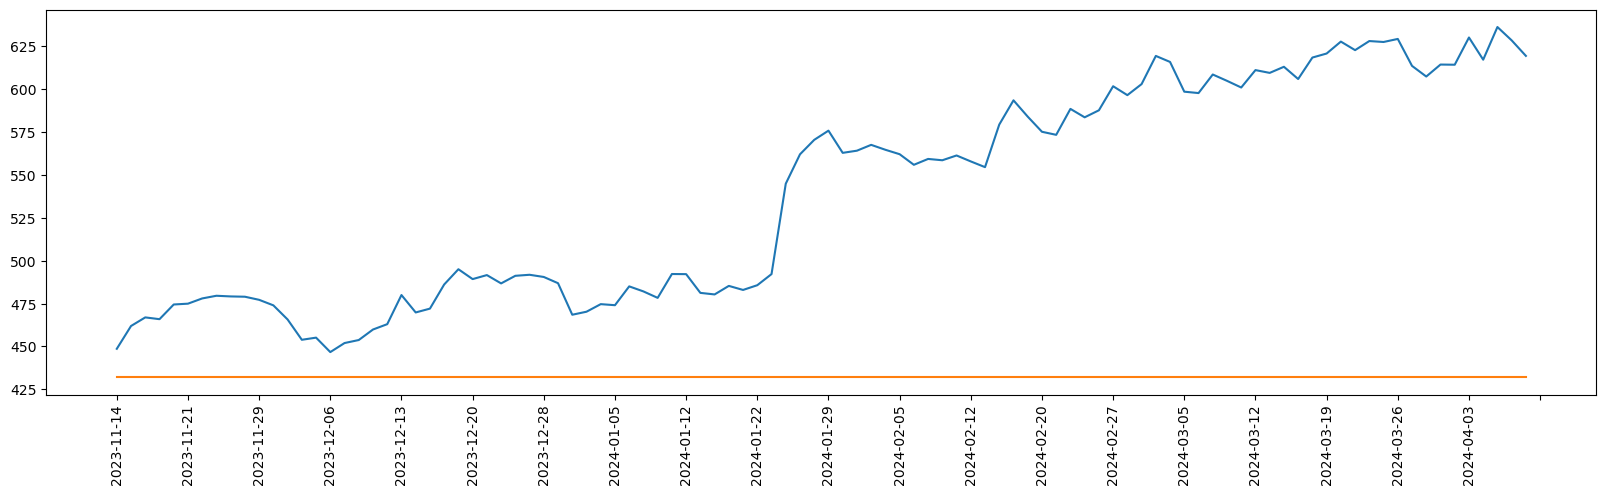

In [15]:
train_split = 0.8
split_idx = int(np.ceil(len(nflx_data)*train_split))
train = nflx_data[['Close']].iloc[:split_idx]
test = nflx_data[['Close']].iloc[split_idx:]
test_pred = np.array([train.rolling(10).mean().iloc[-1]]*len(test)).reshape((-1,1))
print( 'Test RMSE: %.3f' % mean_squared_error(test, test_pred, squared=False))
print( 'Test MAPE: %.3f' % mean_absolute_percentage_error(test, test_pred))
plt.figure(figsize=(20,5))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.plot(test)
plt.plot(test_pred)
plt.xticks(rotation=90)
plt.show()

In [16]:
def predict_using_sma (data, train_split=0.8):
    train_split = train_split
    split_idx = int(np.ceil(len(data)*train_split))
    train = data[['Close']].iloc[:split_idx]
    test = data[['Close']].iloc[split_idx:]
    test_pred = np.array([train.rolling(10).mean().iloc[-1]]*len(test)).reshape((-1,1))
    print( 'Test RMSE: %.3f' % mean_squared_error(test, test_pred, squared=False))
    print( 'Test MAPE: %.3f' % mean_absolute_percentage_error(test, test_pred))
    plt.figure(figsize=(20,5))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.plot(test)
    plt.plot(test_pred)
    plt.xticks(rotation=90)
    plt.show()

# Exponential Moving Average

In [17]:
def predict_using_ema (data, train_split=0.8):
    X = data[['Close']].values
    train_split = train_split
    split_idx = int(np.ceil(len(X)*train_split))
    train = X[:split_idx]
    test = X[split_idx:]
    test_concat = np.array([]).reshape((0, 1))

    for i in range(len(test)):
        train_fit = np.concatenate((train, np.asarray(test_concat)))
        fit = SimpleExpSmoothing(np.asarray(train_fit)).fit(smoothing_level = 0.2)
        test_pred = fit.forecast(1)
        test_concat = np.concatenate((np.asarray(test_concat), test_pred.reshape((-1,1))))

    print('Test RMSE: %.3f' % mean_squared_error(test, test_concat, squared=False))
    print('Test MAPE: %.3f' % mean_absolute_percentage_error(test, test_concat))
    
    plt.figure(figsize=(20,5))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.plot(test)
    plt.plot(test_concat)
    plt.xticks(rotation=90)
    plt.show()

Test RMSE: 122.798
Test MAPE: 0.185


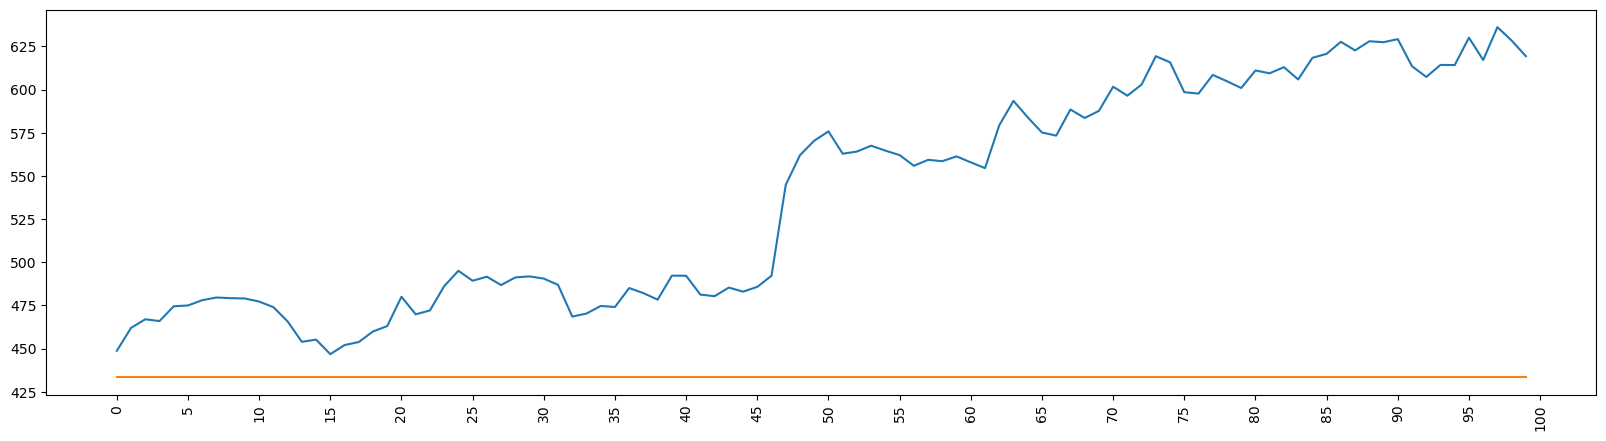

In [18]:
predict_using_ema (nflx_data)

# LSTM

In [19]:
def plot_predicted_vs_actual (predicted, actual):
    plt.figure(figsize=(15,10))
    plt.plot(range(predicted.shape[0]), predicted, label="Predicted")
    plt.plot(range(actual.shape[0]), actual, label="Actual")
    plt.xlabel('Time')
    plt.ylabel('Scaled USD')
    plt.legend()
    plt.show()

Actual feature data shape  : (500, 2, 2)
Actual target data shape   : (500,)
Training feature data shape: (400, 2, 2)
Training target data shape : (400,)
Testing feature data shape : (100, 2, 2)
Testing target data shape  : (100,)
LSTM Summary: 


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
100/100 - 3s - 26ms/step - loss: 0.6673
Epoch 2/50
100/100 - 0s - 2ms/step - loss: 0.2298
Epoch 3/50
100/100 - 0s - 2ms/step - loss: 0.0072
Epoch 4/50
100/100 - 0s - 2ms/step - loss: 0.0049
Epoch 5/50
100/100 - 0s - 4ms/step - loss: 0.0050
Epoch 6/50
100/100 - 0s - 4ms/step - loss: 0.0043
Epoch 7/50
100/100 - 0s - 4ms/step - loss: 0.0042
Epoch 8/50
100/100 - 0s - 3ms/step - loss: 0.0041
Epoch 9/50
100/100 - 0s - 3ms/step - loss: 0.0038
Epoch 10/50
100/100 - 0s - 3ms/step - loss: 0.0036
Epoch 11/50
100/100 - 0s - 3ms/step - loss: 0.0035
Epoch 12/50
100/100 - 0s - 3ms/step - loss: 0.0033
Epoch 13/50
100/100 - 0s - 3ms/step - loss: 0.0032
Epoch 14/50
100/100 - 0s - 3ms/step - loss: 0.0031
Epoch 15/50
100/100 - 0s - 3ms/step - loss: 0.0029
Epoch 16/50
100/100 - 0s - 3ms/step - loss: 0.0028
Epoch 17/50
100/100 - 0s - 4ms/step - loss: 0.0027
Epoch 18/50
100/100 - 0s - 4ms/step - loss: 0.0026
Epoch 19/50
100/100 - 0s - 2ms/step - loss: 0.0025
Epoch 20/50
100/100 - 0s - 3ms/ste

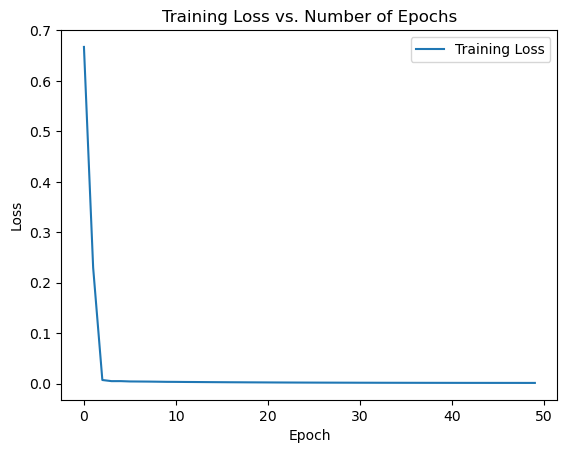

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
RSME : 0.2917313074515084
MAPE : 0.12306593700032051


In [20]:
lstm, y_pred, y_test = predict_using_lstm(nflx_data)

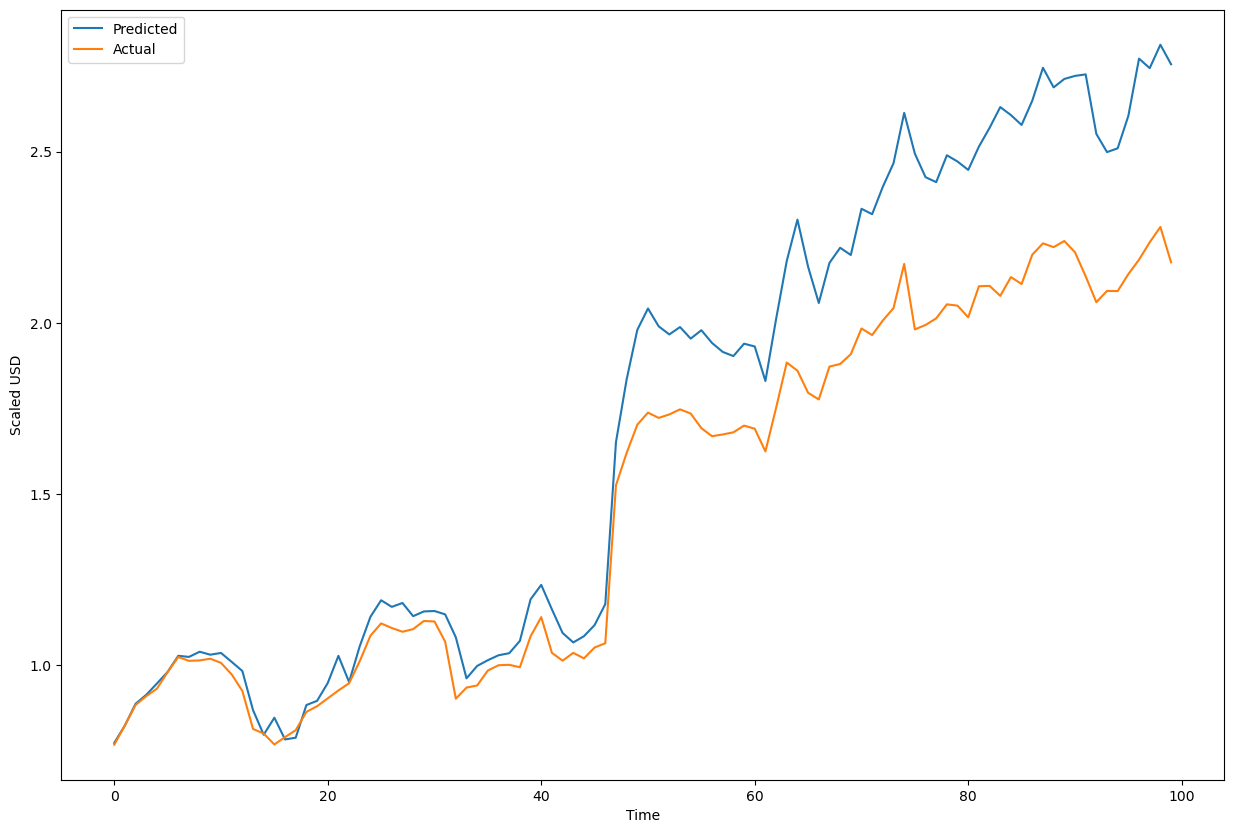

In [21]:
plot_predicted_vs_actual (y_pred, y_test)

Actual feature data shape  : (492, 10, 2)
Actual target data shape   : (492,)
Training feature data shape: (394, 10, 2)
Training target data shape : (394,)
Testing feature data shape : (98, 10, 2)
Testing target data shape  : (98,)
LSTM Summary: 


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
99/99 - 3s - 29ms/step - loss: 0.3758
Epoch 2/50
99/99 - 0s - 4ms/step - loss: 0.0250
Epoch 3/50
99/99 - 1s - 8ms/step - loss: 0.0135
Epoch 4/50
99/99 - 0s - 5ms/step - loss: 0.0117
Epoch 5/50
99/99 - 1s - 7ms/step - loss: 0.0101
Epoch 6/50
99/99 - 1s - 7ms/step - loss: 0.0092
Epoch 7/50
99/99 - 1s - 7ms/step - loss: 0.0077
Epoch 8/50
99/99 - 1s - 7ms/step - loss: 0.0072
Epoch 9/50
99/99 - 0s - 4ms/step - loss: 0.0060
Epoch 10/50
99/99 - 1s - 8ms/step - loss: 0.0050
Epoch 11/50
99/99 - 0s - 5ms/step - loss: 0.0040
Epoch 12/50
99/99 - 1s - 7ms/step - loss: 0.0035
Epoch 13/50
99/99 - 1s - 5ms/step - loss: 0.0031
Epoch 14/50
99/99 - 1s - 7ms/step - loss: 0.0028
Epoch 15/50
99/99 - 0s - 5ms/step - loss: 0.0025
Epoch 16/50
99/99 - 1s - 6ms/step - loss: 0.0022
Epoch 17/50
99/99 - 1s - 7ms/step - loss: 0.0020
Epoch 18/50
99/99 - 1s - 7ms/step - loss: 0.0019
Epoch 19/50
99/99 - 1s - 7ms/step - loss: 0.0017
Epoch 20/50
99/99 - 0s - 5ms/step - loss: 0.0015
Epoch 21/50
99/99 - 1s 

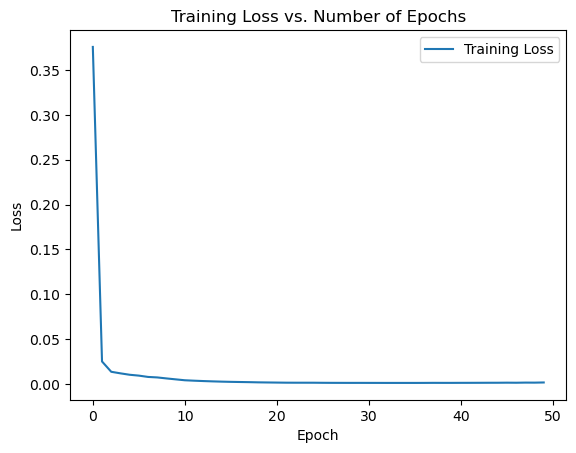

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
RSME : 0.04129118310064594
MAPE : 0.024238518297710482


In [22]:
lstm1, y_pred1, y_test1 = predict_using_lstm(nflx_data, n_steps = 10)

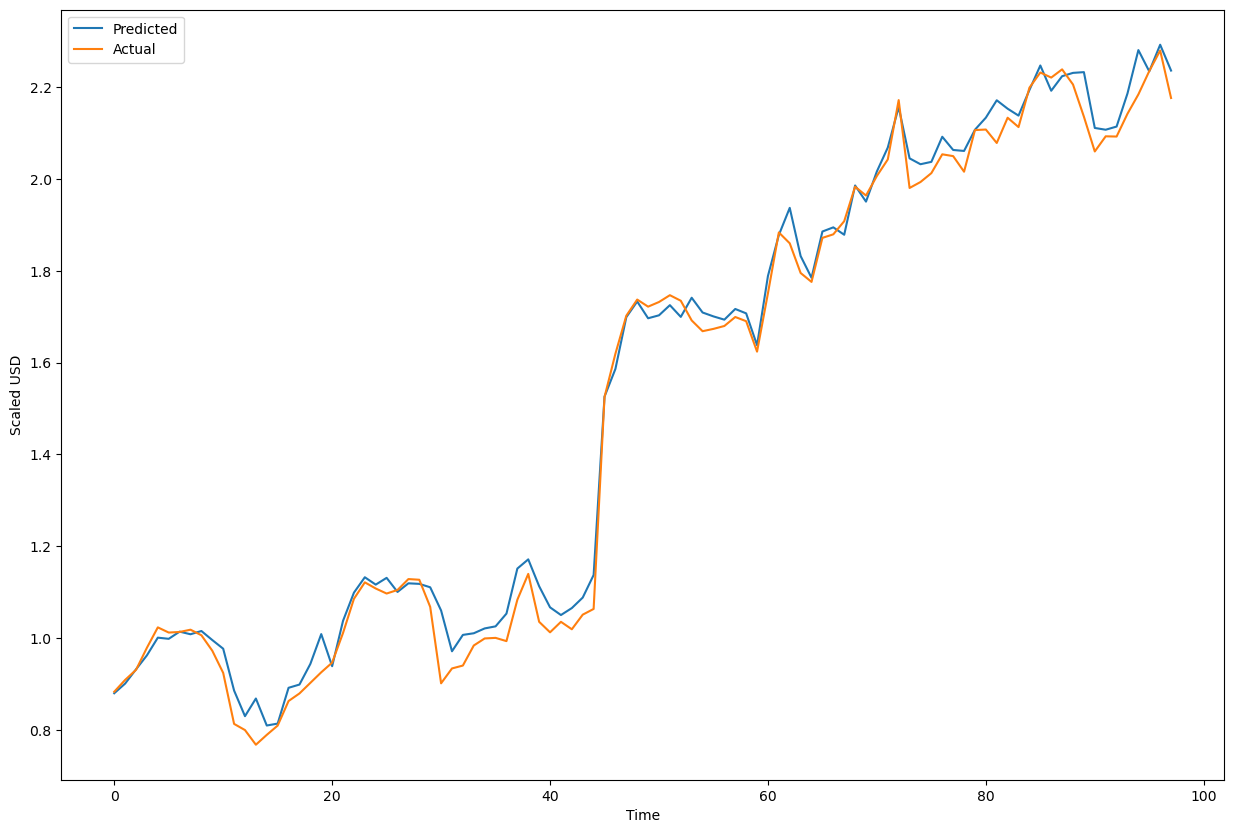

In [23]:
plot_predicted_vs_actual (y_pred1, y_test1)

Actual feature data shape  : (500, 2, 2)
Actual target data shape   : (500,)
Training feature data shape: (400, 2, 2)
Training target data shape : (400,)
Testing feature data shape : (100, 2, 2)
Testing target data shape  : (100,)
LSTM Summary: 


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
100/100 - 3s - 26ms/step - loss: 0.5970
Epoch 2/50
100/100 - 0s - 2ms/step - loss: 0.2907
Epoch 3/50
100/100 - 0s - 2ms/step - loss: 0.0275
Epoch 4/50
100/100 - 0s - 4ms/step - loss: 0.0046
Epoch 5/50
100/100 - 0s - 3ms/step - loss: 0.0033
Epoch 6/50
100/100 - 0s - 3ms/step - loss: 0.0033
Epoch 7/50
100/100 - 0s - 3ms/step - loss: 0.0032
Epoch 8/50
100/100 - 0s - 3ms/step - loss: 0.0032
Epoch 9/50
100/100 - 0s - 3ms/step - loss: 0.0031
Epoch 10/50
100/100 - 0s - 4ms/step - loss: 0.0030
Epoch 11/50
100/100 - 0s - 3ms/step - loss: 0.0030
Epoch 12/50
100/100 - 0s - 2ms/step - loss: 0.0029
Epoch 13/50
100/100 - 0s - 4ms/step - loss: 0.0028
Epoch 14/50
100/100 - 0s - 3ms/step - loss: 0.0027
Epoch 15/50
100/100 - 0s - 3ms/step - loss: 0.0026
Epoch 16/50
100/100 - 0s - 3ms/step - loss: 0.0026
Epoch 17/50
100/100 - 0s - 3ms/step - loss: 0.0025
Epoch 18/50
100/100 - 0s - 3ms/step - loss: 0.0024
Epoch 19/50
100/100 - 0s - 2ms/step - loss: 0.0023
Epoch 20/50
100/100 - 0s - 4ms/ste

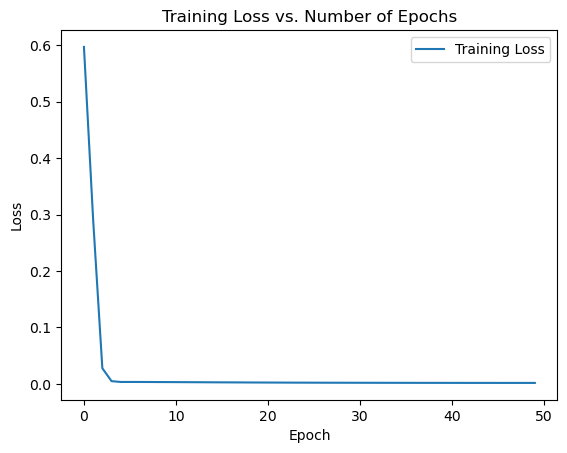

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000277F16569E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
RSME : 0.28805140444373456
MAPE : 0.12130463976752029


In [24]:
lstm2, y_pred2, y_test2 = predict_using_lstm(nflx_data, lstm_units=50)

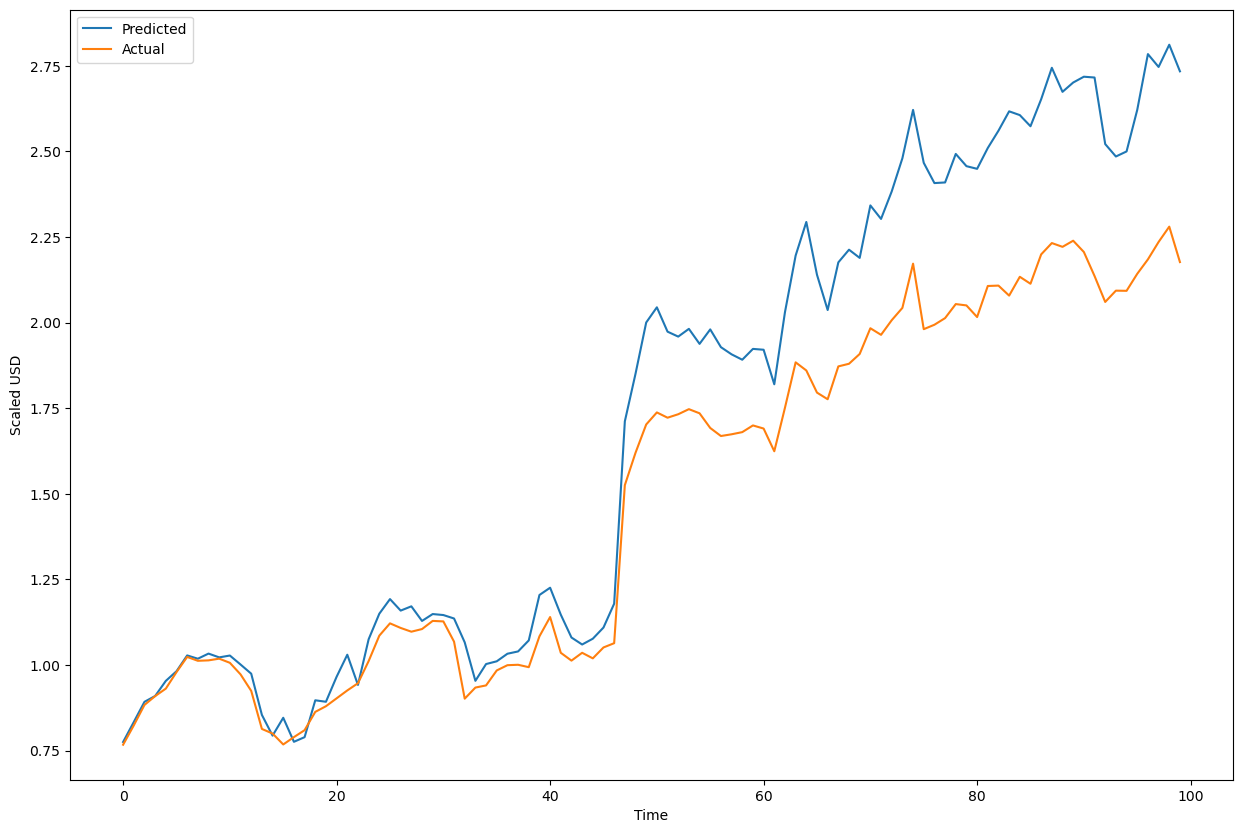

In [25]:
plot_predicted_vs_actual (y_pred2, y_test2)

Actual feature data shape  : (492, 10, 2)
Actual target data shape   : (492,)
Training feature data shape: (394, 10, 2)
Training target data shape : (394,)
Testing feature data shape : (98, 10, 2)
Testing target data shape  : (98,)
LSTM Summary: 


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
99/99 - 3s - 31ms/step - loss: 0.4028
Epoch 2/50
99/99 - 0s - 4ms/step - loss: 0.0204
Epoch 3/50
99/99 - 0s - 5ms/step - loss: 0.0142
Epoch 4/50
99/99 - 0s - 4ms/step - loss: 0.0120
Epoch 5/50
99/99 - 1s - 5ms/step - loss: 0.0102
Epoch 6/50
99/99 - 0s - 4ms/step - loss: 0.0088
Epoch 7/50
99/99 - 0s - 5ms/step - loss: 0.0074
Epoch 8/50
99/99 - 1s - 7ms/step - loss: 0.0064
Epoch 9/50
99/99 - 0s - 4ms/step - loss: 0.0057
Epoch 10/50
99/99 - 0s - 5ms/step - loss: 0.0051
Epoch 11/50
99/99 - 0s - 5ms/step - loss: 0.0048
Epoch 12/50
99/99 - 1s - 7ms/step - loss: 0.0044
Epoch 13/50
99/99 - 1s - 7ms/step - loss: 0.0043
Epoch 14/50
99/99 - 0s - 4ms/step - loss: 0.0040
Epoch 15/50
99/99 - 1s - 7ms/step - loss: 0.0037
Epoch 16/50
99/99 - 0s - 5ms/step - loss: 0.0034
Epoch 17/50
99/99 - 1s - 6ms/step - loss: 0.0032
Epoch 18/50
99/99 - 1s - 8ms/step - loss: 0.0029
Epoch 19/50
99/99 - 1s - 6ms/step - loss: 0.0026
Epoch 20/50
99/99 - 0s - 5ms/step - loss: 0.0024
Epoch 21/50
99/99 - 1s 

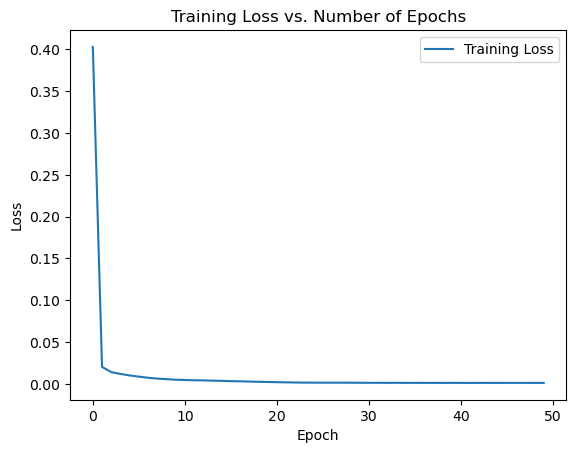

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
RSME : 0.11655097602574738
MAPE : 0.05796506501315741


In [26]:
lstm3, y_pred3, y_test3 = predict_using_lstm(nflx_data, n_steps = 10, lstm_units=50)

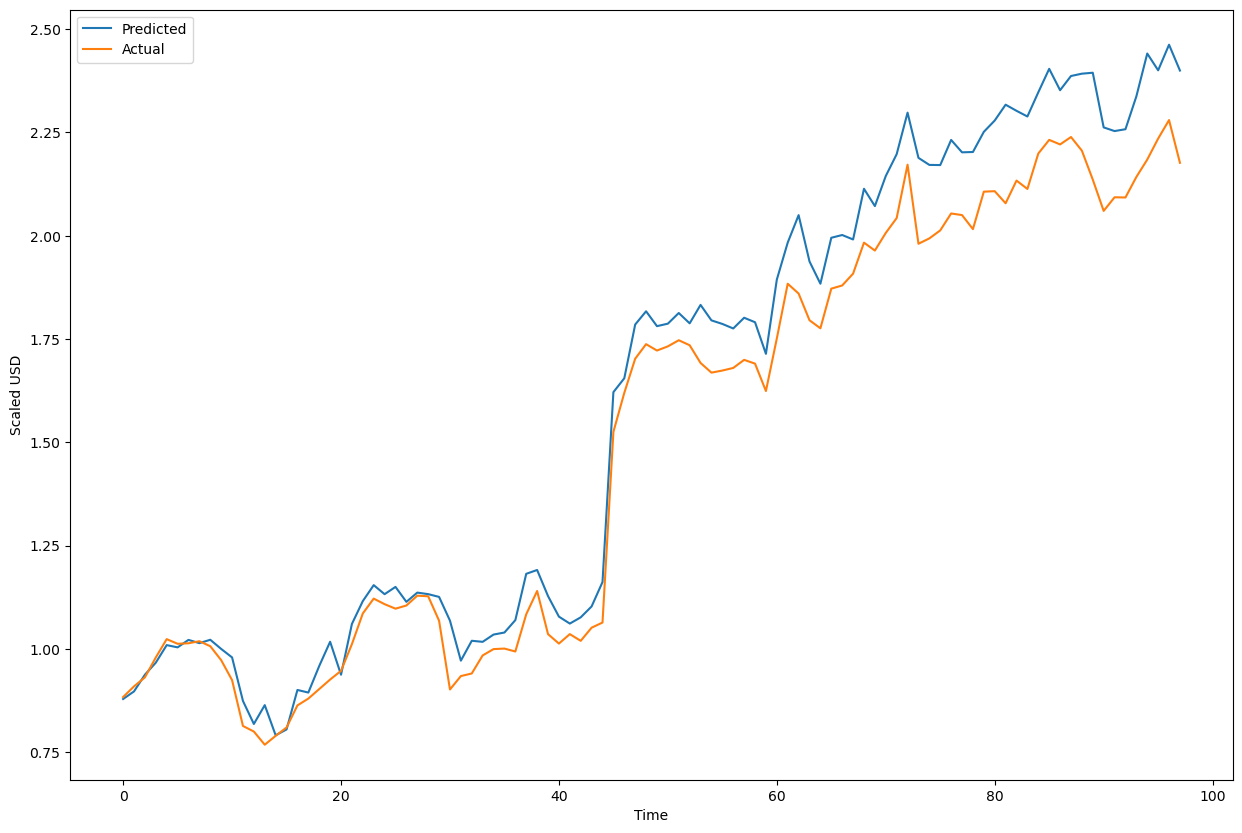

In [27]:
plot_predicted_vs_actual (y_pred3, y_test3)

# 5 years Netflix data

### LSTM

In [28]:
nflx_5_yrs_data = pd.read_csv('./NFLX_5_yrs.csv', index_col='Date')

In [29]:
nflx_5_yrs_data.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-04-09  360.540009  366.739990  359.000000  364.709991  364.709991   
2019-04-10  365.790009  368.850006  362.250000  363.920013  363.920013   
2019-04-11  365.000000  370.119995  360.809998  367.649994  367.649994   
2019-04-12  360.690002  361.750000  349.359985  351.140015  351.140015   
2019-04-15  350.709991  352.209991  342.269989  348.869995  348.869995   

              Volume  
Date                  
2019-04-09   5439200  
2019-04-10   4545600  
2019-04-11   6526900  
2019-04-12  15646200  
2019-04-15   8842300

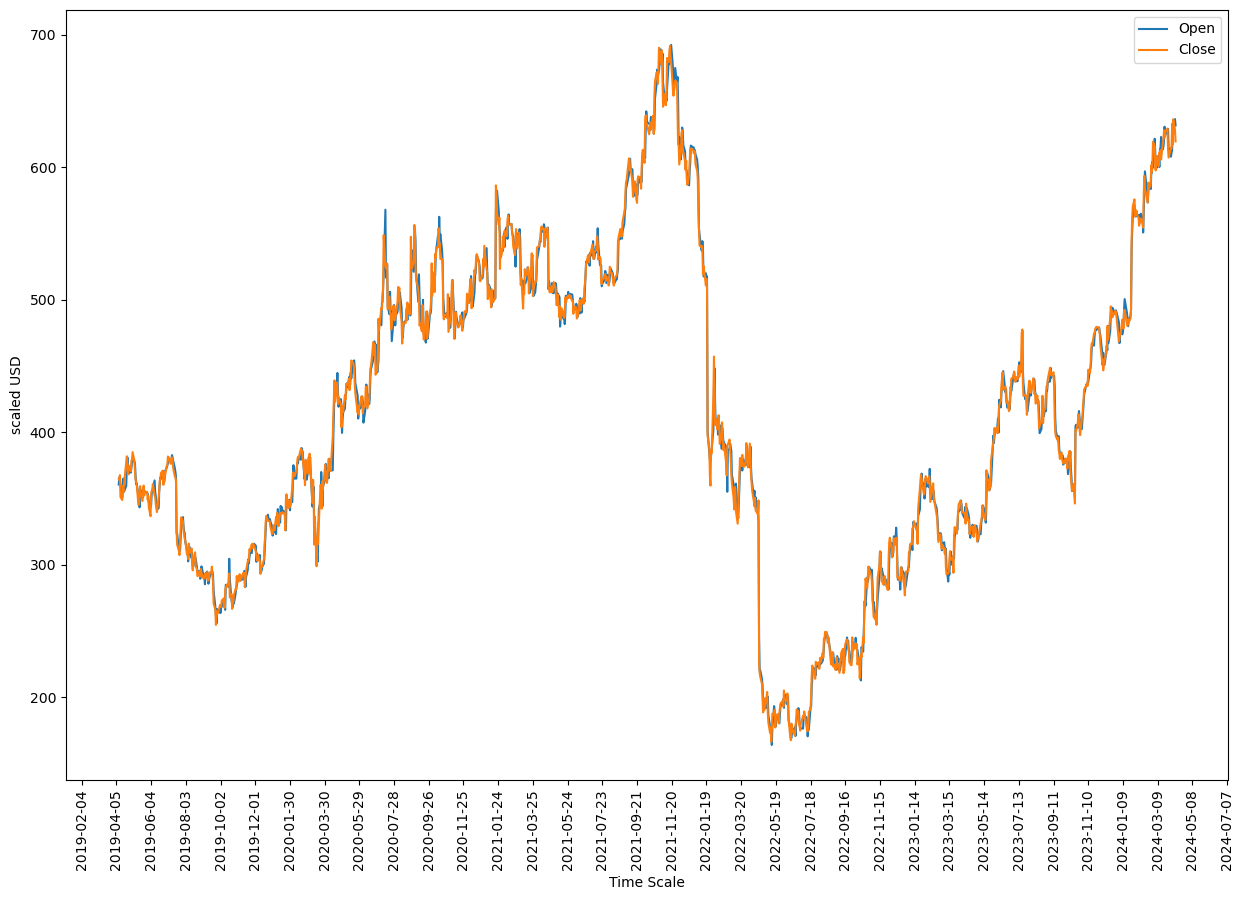

In [30]:
plot_init_graph (nflx_5_yrs_data, features = ['Open', 'Close'])

Actual feature data shape  : (492, 10, 2)
Actual target data shape   : (492,)
Training feature data shape: (394, 10, 2)
Training target data shape : (394,)
Testing feature data shape : (98, 10, 2)
Testing target data shape  : (98,)
LSTM Summary: 


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
99/99 - 4s - 37ms/step - loss: 0.3006
Epoch 2/50
99/99 - 0s - 4ms/step - loss: 0.0168
Epoch 3/50
99/99 - 0s - 5ms/step - loss: 0.0171
Epoch 4/50
99/99 - 1s - 7ms/step - loss: 0.0122
Epoch 5/50
99/99 - 0s - 5ms/step - loss: 0.0106
Epoch 6/50
99/99 - 1s - 7ms/step - loss: 0.0093
Epoch 7/50
99/99 - 1s - 7ms/step - loss: 0.0080
Epoch 8/50
99/99 - 1s - 5ms/step - loss: 0.0073
Epoch 9/50
99/99 - 0s - 4ms/step - loss: 0.0065
Epoch 10/50
99/99 - 0s - 4ms/step - loss: 0.0058
Epoch 11/50
99/99 - 1s - 7ms/step - loss: 0.0052
Epoch 12/50
99/99 - 1s - 7ms/step - loss: 0.0047
Epoch 13/50
99/99 - 0s - 5ms/step - loss: 0.0043
Epoch 14/50
99/99 - 0s - 4ms/step - loss: 0.0039
Epoch 15/50
99/99 - 0s - 4ms/step - loss: 0.0035
Epoch 16/50
99/99 - 0s - 4ms/step - loss: 0.0032
Epoch 17/50
99/99 - 0s - 4ms/step - loss: 0.0028
Epoch 18/50
99/99 - 1s - 8ms/step - loss: 0.0025
Epoch 19/50
99/99 - 0s - 4ms/step - loss: 0.0022
Epoch 20/50
99/99 - 0s - 4ms/step - loss: 0.0019
Epoch 21/50
99/99 - 1s 

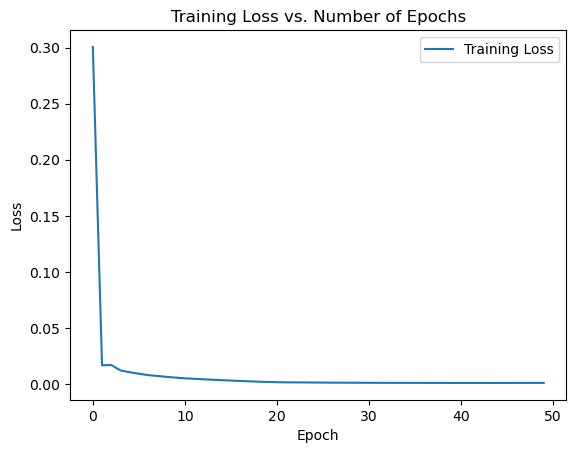

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
RSME : 0.04815076566984677
MAPE : 0.027415871365688647


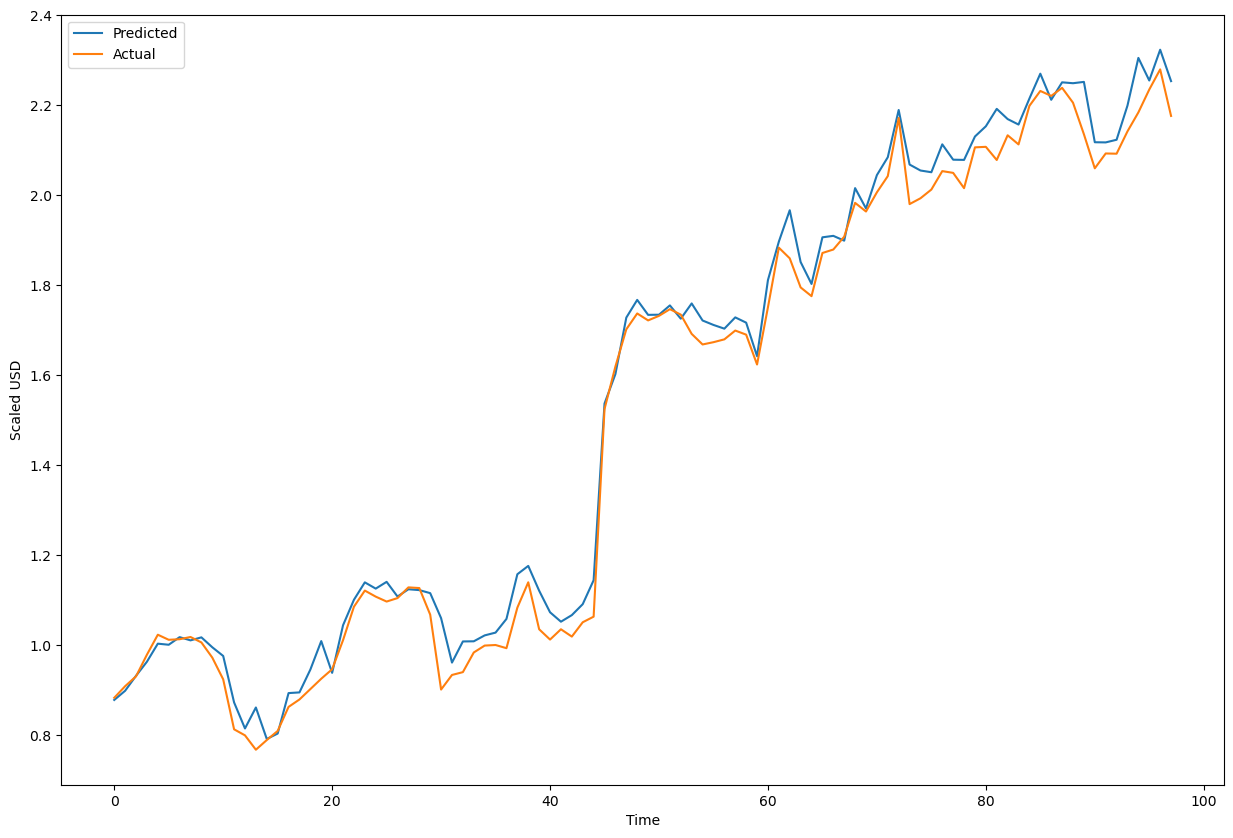

In [31]:
lstm5, y_pred5, y_test5 = predict_using_lstm(nflx_5_yrs_data, n_steps = 10)
plot_predicted_vs_actual (y_pred5, y_test5)

### EMA

Test RMSE: 145.027
Test MAPE: 0.238


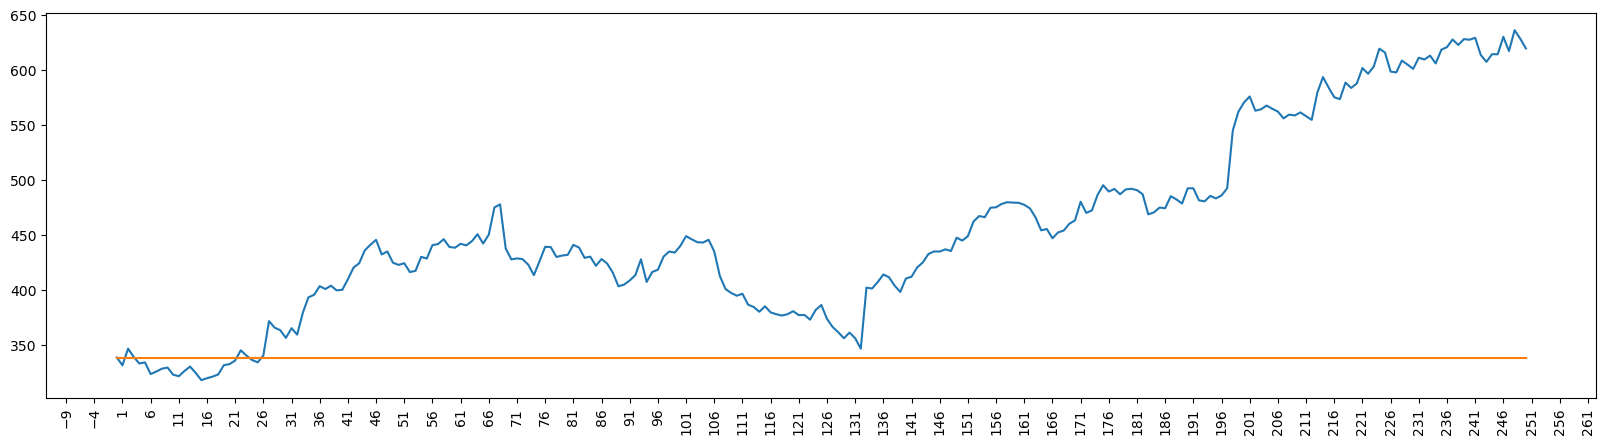

In [32]:
predict_using_ema (nflx_5_yrs_data)

# SMA

Test RMSE: 144.216
Test MAPE: 0.236


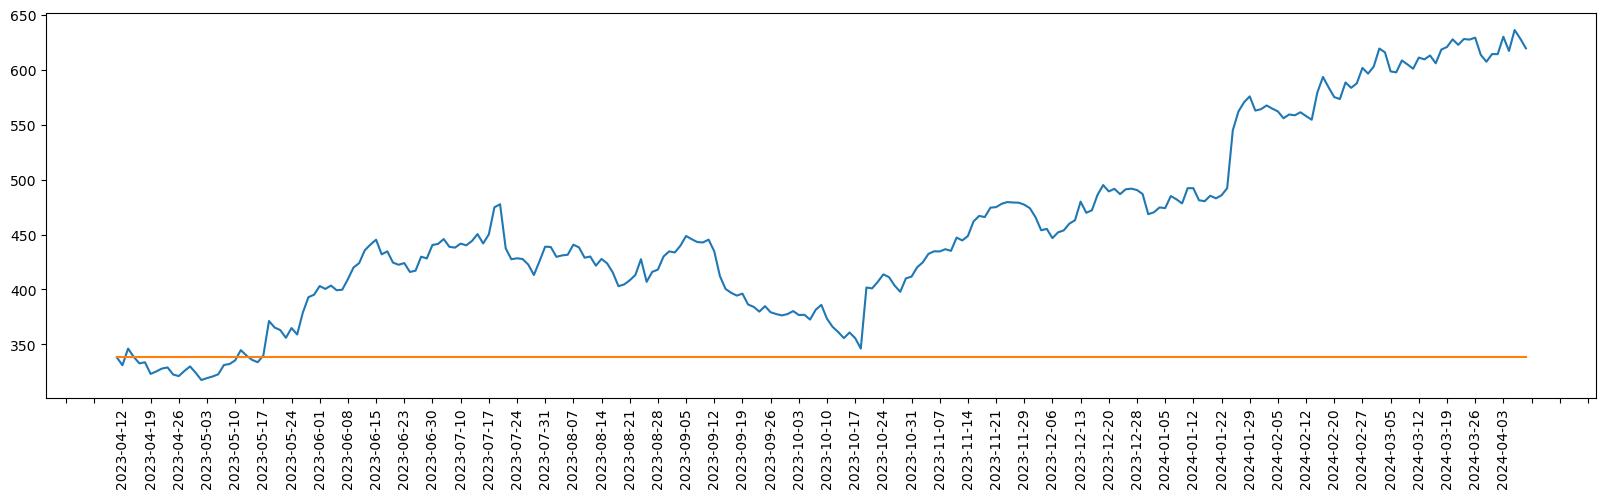

In [33]:
predict_using_sma (nflx_5_yrs_data)

# 2 years Apple data

### LSTM

In [34]:
appl_data = pd.read_csv('./AAPL.csv', index_col='Date')
appl_data.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-04-18  163.919998  166.600006  163.570007  165.070007  163.204956   
2022-04-19  165.020004  167.820007  163.910004  167.399994  165.508621   
2022-04-20  168.759995  168.880005  166.100006  167.229996  165.340530   
2022-04-21  168.910004  171.529999  165.910004  166.419998  164.539673   
2022-04-22  166.460007  167.869995  161.500000  161.789993  159.961990   

              Volume  
Date                  
2022-04-18  69023900  
2022-04-19  67723800  
2022-04-20  67929800  
2022-04-21  87227800  
2022-04-22  84882400

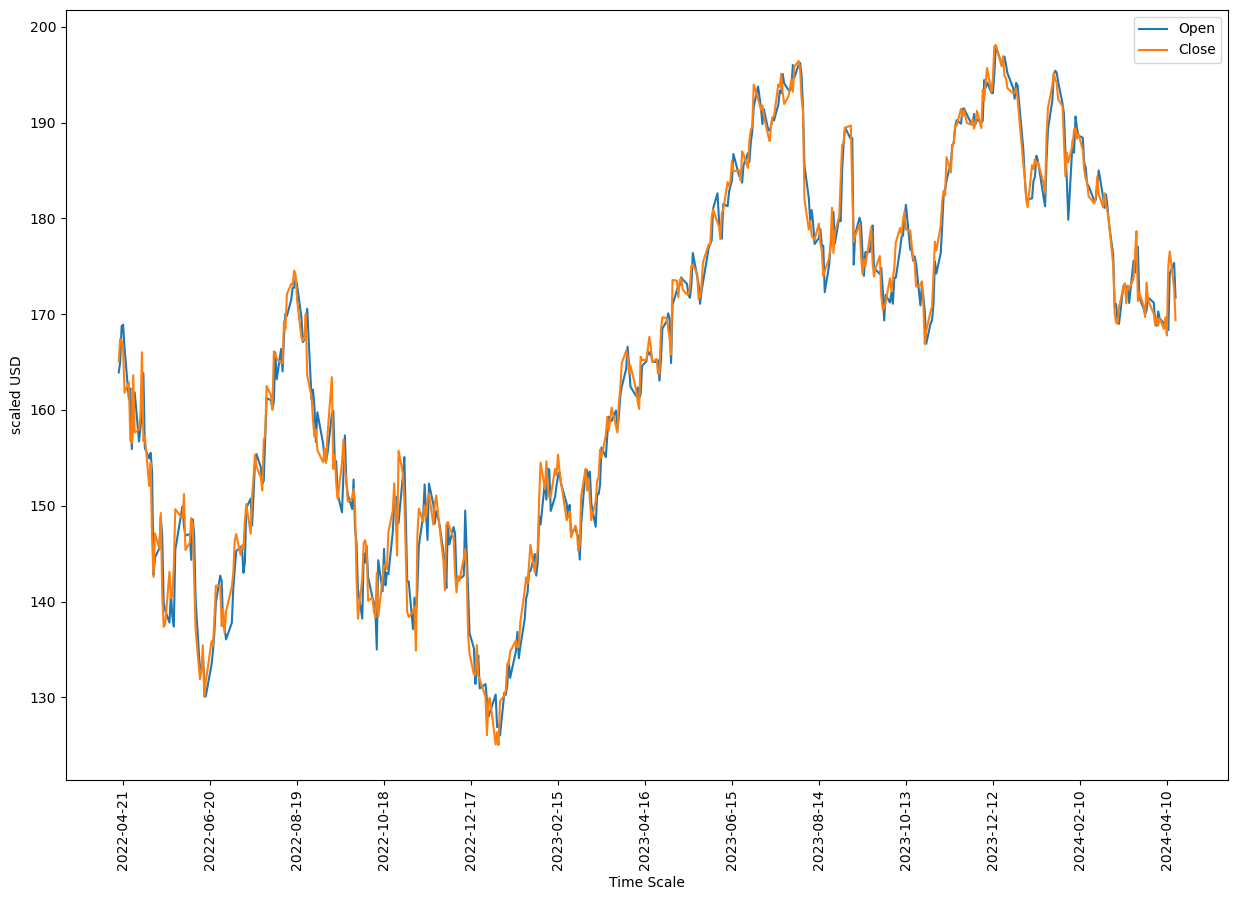

In [35]:
plot_init_graph (appl_data, features = ['Open', 'Close'])

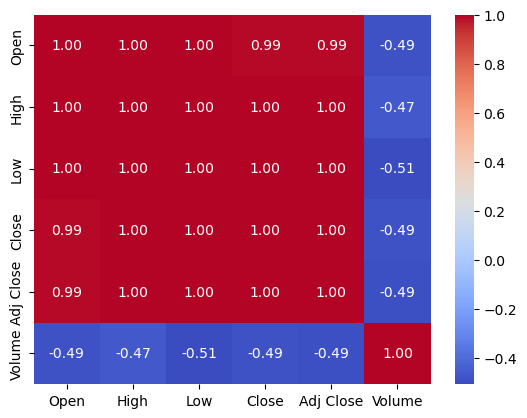

In [36]:
appl_correlation_matrix = appl_data.corr()
sns.heatmap(appl_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Actual feature data shape  : (492, 10, 2)
Actual target data shape   : (492,)
Training feature data shape: (394, 10, 2)
Training target data shape : (394,)
Testing feature data shape : (98, 10, 2)
Testing target data shape  : (98,)
LSTM Summary: 


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
99/99 - 4s - 37ms/step - loss: 0.2770
Epoch 2/50
99/99 - 0s - 5ms/step - loss: 0.0156
Epoch 3/50
99/99 - 0s - 4ms/step - loss: 0.0172
Epoch 4/50
99/99 - 1s - 7ms/step - loss: 0.0119
Epoch 5/50
99/99 - 0s - 5ms/step - loss: 0.0102
Epoch 6/50
99/99 - 0s - 5ms/step - loss: 0.0089
Epoch 7/50
99/99 - 0s - 5ms/step - loss: 0.0080
Epoch 8/50
99/99 - 1s - 7ms/step - loss: 0.0068
Epoch 9/50
99/99 - 1s - 8ms/step - loss: 0.0062
Epoch 10/50
99/99 - 1s - 6ms/step - loss: 0.0057
Epoch 11/50
99/99 - 1s - 8ms/step - loss: 0.0052
Epoch 12/50
99/99 - 1s - 5ms/step - loss: 0.0050
Epoch 13/50
99/99 - 1s - 5ms/step - loss: 0.0046
Epoch 14/50
99/99 - 0s - 4ms/step - loss: 0.0043
Epoch 15/50
99/99 - 1s - 9ms/step - loss: 0.0038
Epoch 16/50
99/99 - 0s - 5ms/step - loss: 0.0036
Epoch 17/50
99/99 - 1s - 7ms/step - loss: 0.0034
Epoch 18/50
99/99 - 0s - 4ms/step - loss: 0.0031
Epoch 19/50
99/99 - 1s - 5ms/step - loss: 0.0029
Epoch 20/50
99/99 - 0s - 5ms/step - loss: 0.0028
Epoch 21/50
99/99 - 1s 

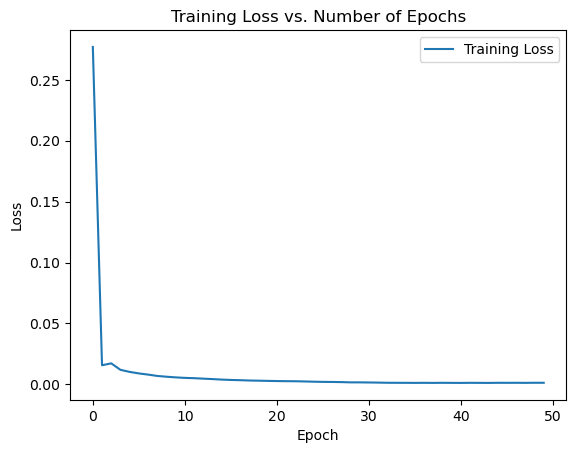

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
RSME : 0.3204963339030506
MAPE : 0.1306120417729651


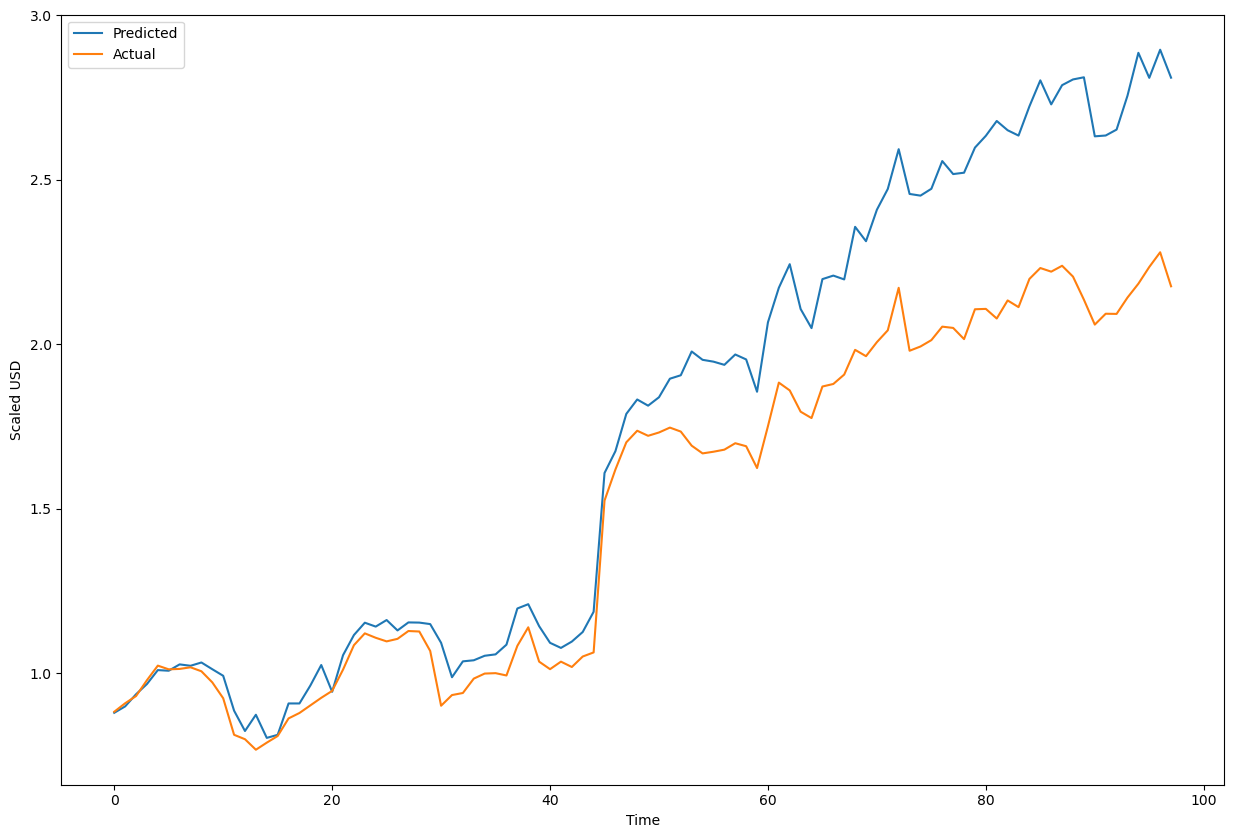

In [37]:
apl_lstm, apl_y_pred, apl_y_test = predict_using_lstm(appl_data, n_steps = 10)
plot_predicted_vs_actual (apl_y_pred, apl_y_test)

### EMA

Test RMSE: 9.698
Test MAPE: 0.044


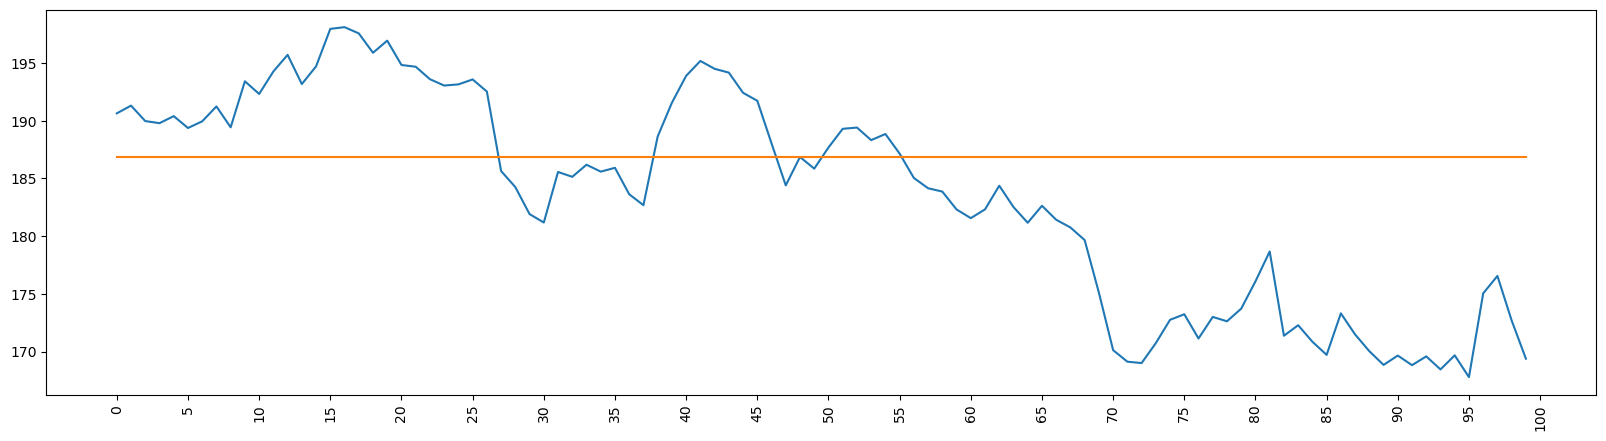

In [38]:
predict_using_ema (appl_data)

# SMA

Test RMSE: 9.571
Test MAPE: 0.044


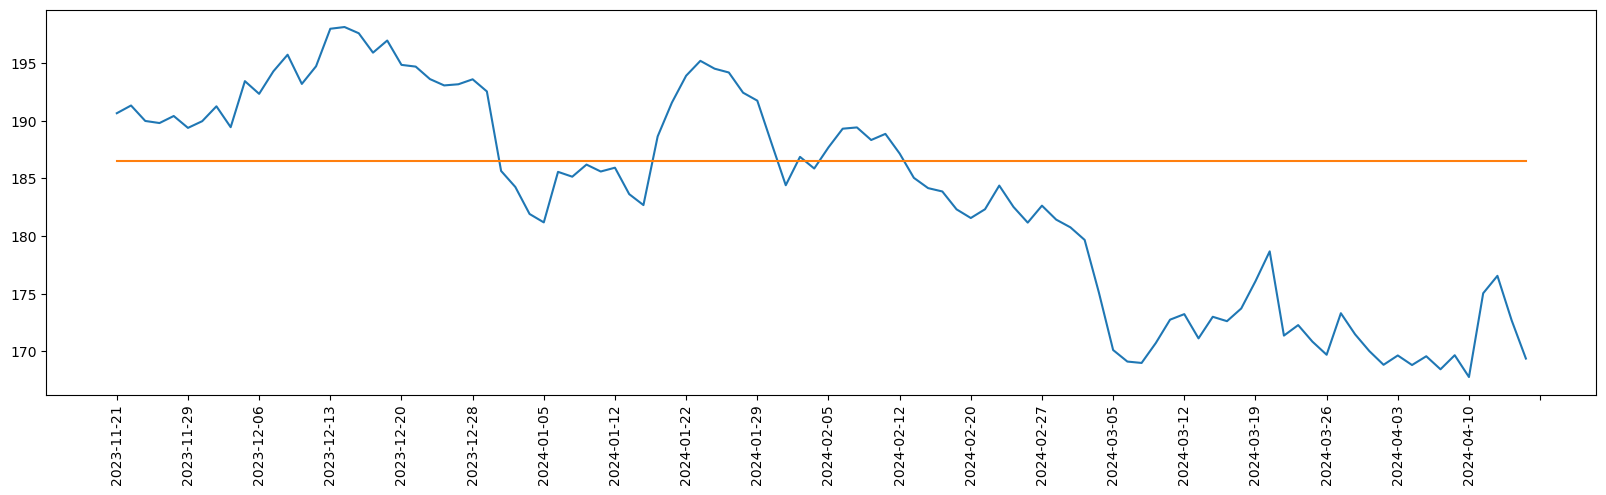

In [39]:
predict_using_sma (appl_data)

# 1 year Apple data

### LSTM

In [40]:
appl_1_yr_data = pd.read_csv('./AAPL_1_yr.csv', index_col='Date')
appl_1_yr_data.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-17  165.089996  165.389999  164.029999  165.229996  164.352737   
2023-04-18  166.100006  167.410004  165.649994  166.470001  165.586151   
2023-04-19  165.800003  168.160004  165.539993  167.630005  166.740021   
2023-04-20  166.089996  167.869995  165.559998  166.649994  165.765182   
2023-04-21  165.050003  166.449997  164.490005  165.020004  164.143860   

              Volume  
Date                  
2023-04-17  41516200  
2023-04-18  49923000  
2023-04-19  47720200  
2023-04-20  52456400  
2023-04-21  58337300

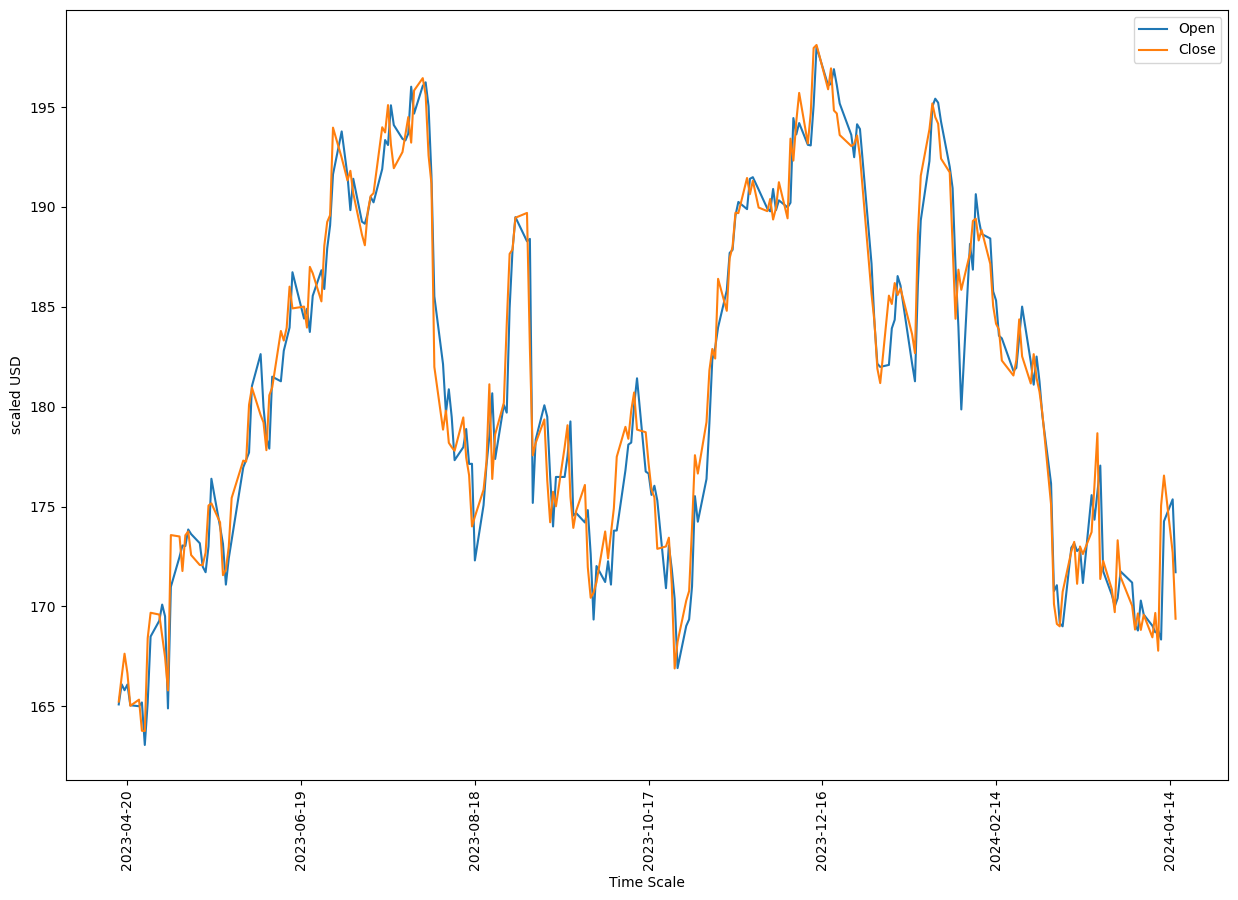

In [41]:
plot_init_graph (appl_1_yr_data, features = ['Open', 'Close'])

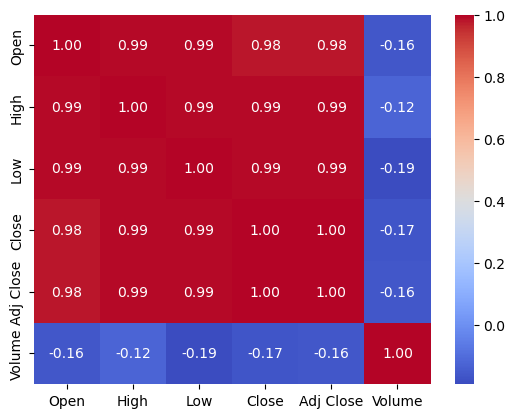

In [42]:
appl1_correlation_matrix = appl_1_yr_data.corr()
sns.heatmap(appl1_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Actual feature data shape  : (492, 10, 2)
Actual target data shape   : (492,)
Training feature data shape: (394, 10, 2)
Training target data shape : (394,)
Testing feature data shape : (98, 10, 2)
Testing target data shape  : (98,)
LSTM Summary: 


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
99/99 - 3s - 30ms/step - loss: 0.3001
Epoch 2/50
99/99 - 0s - 4ms/step - loss: 0.0265
Epoch 3/50
99/99 - 1s - 8ms/step - loss: 0.0137
Epoch 4/50
99/99 - 1s - 6ms/step - loss: 0.0114
Epoch 5/50
99/99 - 1s - 7ms/step - loss: 0.0101
Epoch 6/50
99/99 - 1s - 8ms/step - loss: 0.0088
Epoch 7/50
99/99 - 0s - 4ms/step - loss: 0.0078
Epoch 8/50
99/99 - 0s - 4ms/step - loss: 0.0070
Epoch 9/50
99/99 - 1s - 6ms/step - loss: 0.0062
Epoch 10/50
99/99 - 0s - 4ms/step - loss: 0.0054
Epoch 11/50
99/99 - 1s - 8ms/step - loss: 0.0048
Epoch 12/50
99/99 - 1s - 7ms/step - loss: 0.0041
Epoch 13/50
99/99 - 1s - 6ms/step - loss: 0.0036
Epoch 14/50
99/99 - 0s - 4ms/step - loss: 0.0030
Epoch 15/50
99/99 - 0s - 4ms/step - loss: 0.0026
Epoch 16/50
99/99 - 0s - 4ms/step - loss: 0.0022
Epoch 17/50
99/99 - 0s - 4ms/step - loss: 0.0019
Epoch 18/50
99/99 - 0s - 4ms/step - loss: 0.0017
Epoch 19/50
99/99 - 0s - 4ms/step - loss: 0.0017
Epoch 20/50
99/99 - 0s - 4ms/step - loss: 0.0016
Epoch 21/50
99/99 - 0s 

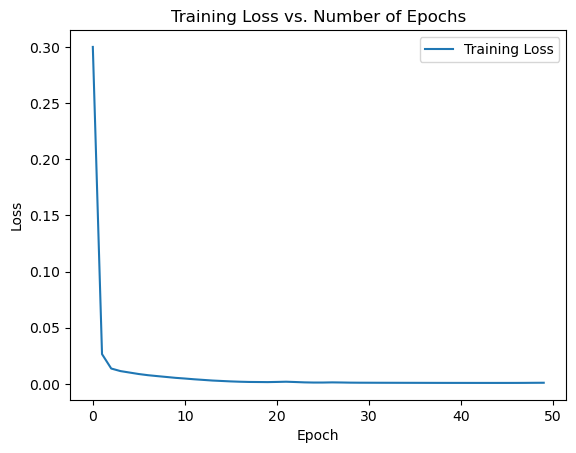

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
RSME : 0.16155796323845573
MAPE : 0.07679316786510249


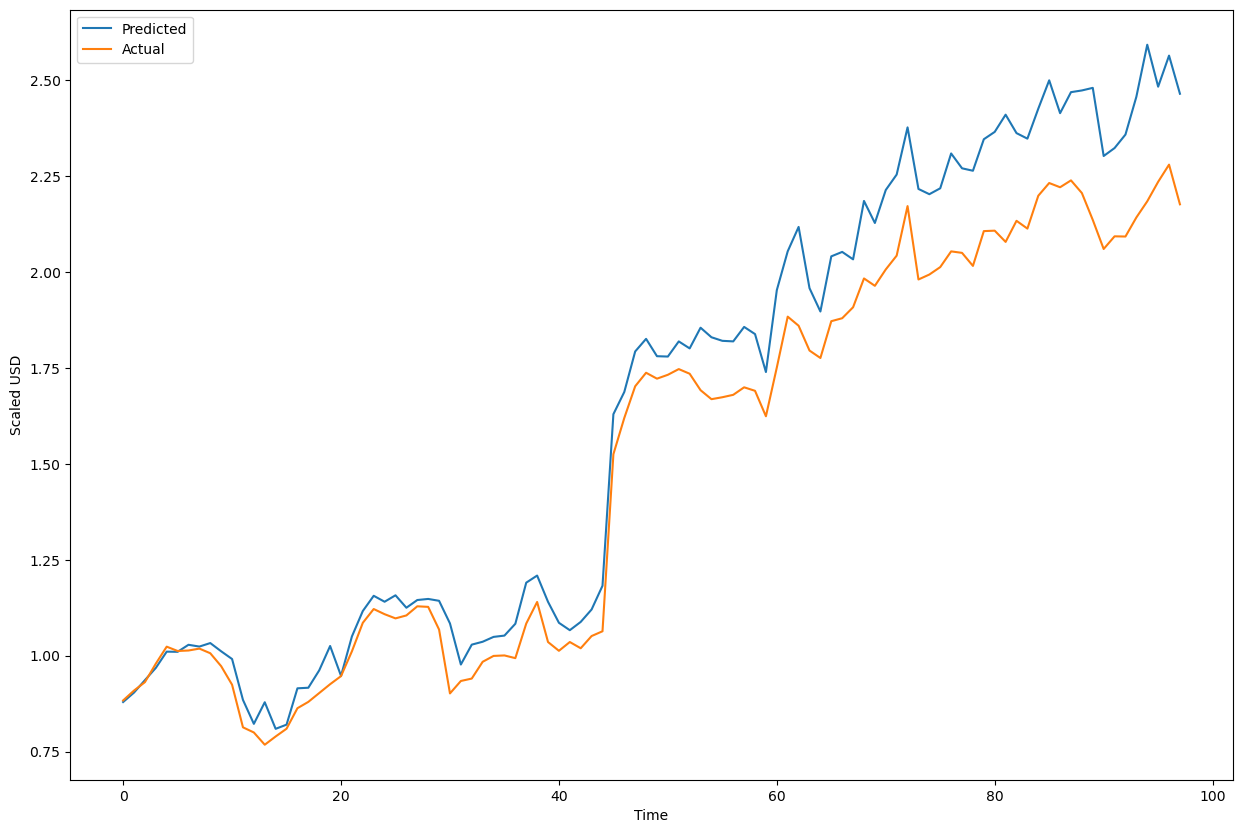

In [43]:
apl_lstm1, apl_y_pred1, apl_y_test1 = predict_using_lstm(appl_1_yr_data, n_steps = 10)
plot_predicted_vs_actual (apl_y_pred1, apl_y_test1)

### EMA

Test RMSE: 13.735
Test MAPE: 0.070


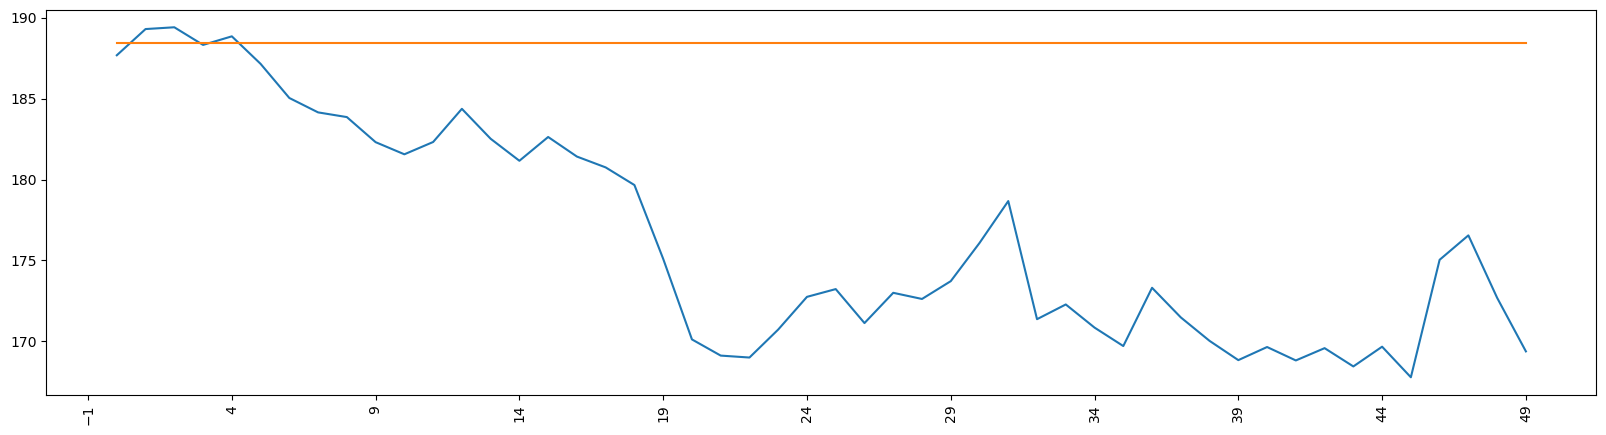

In [44]:
predict_using_ema (appl_1_yr_data)

# SMA

Test RMSE: 15.770
Test MAPE: 0.082


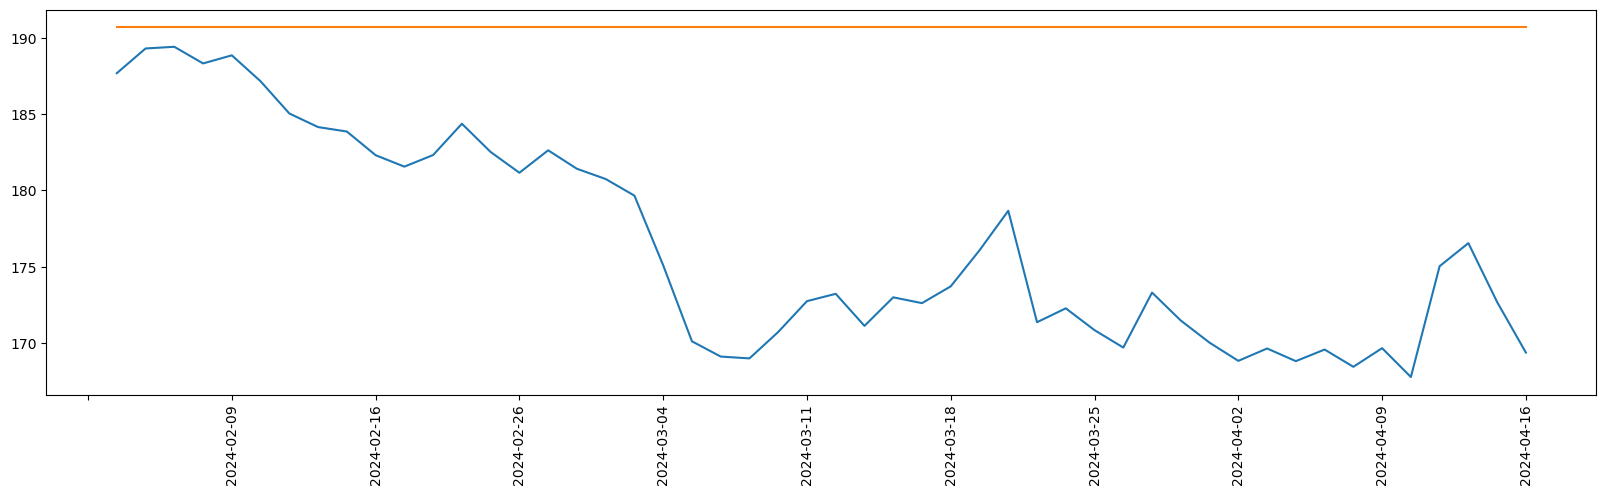

In [45]:
predict_using_sma (appl_1_yr_data)

# Tesla 2 years data

In [46]:
tsla_data = pd.read_csv('./TSLA.csv', index_col='Date')
tsla_data.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-17  186.320007  189.690002  182.690002  187.039993  187.039993   
2023-04-18  187.149994  187.690002  183.580002  184.309998  184.309998   
2023-04-19  179.100006  183.500000  177.649994  180.589996  180.589996   
2023-04-20  166.169998  169.699997  160.559998  162.990005  162.990005   
2023-04-21  164.800003  166.000000  161.320007  165.080002  165.080002   

               Volume  
Date                   
2023-04-17  116662200  
2023-04-18   92067000  
2023-04-19  125732700  
2023-04-20  210970800  
2023-04-21  123539000

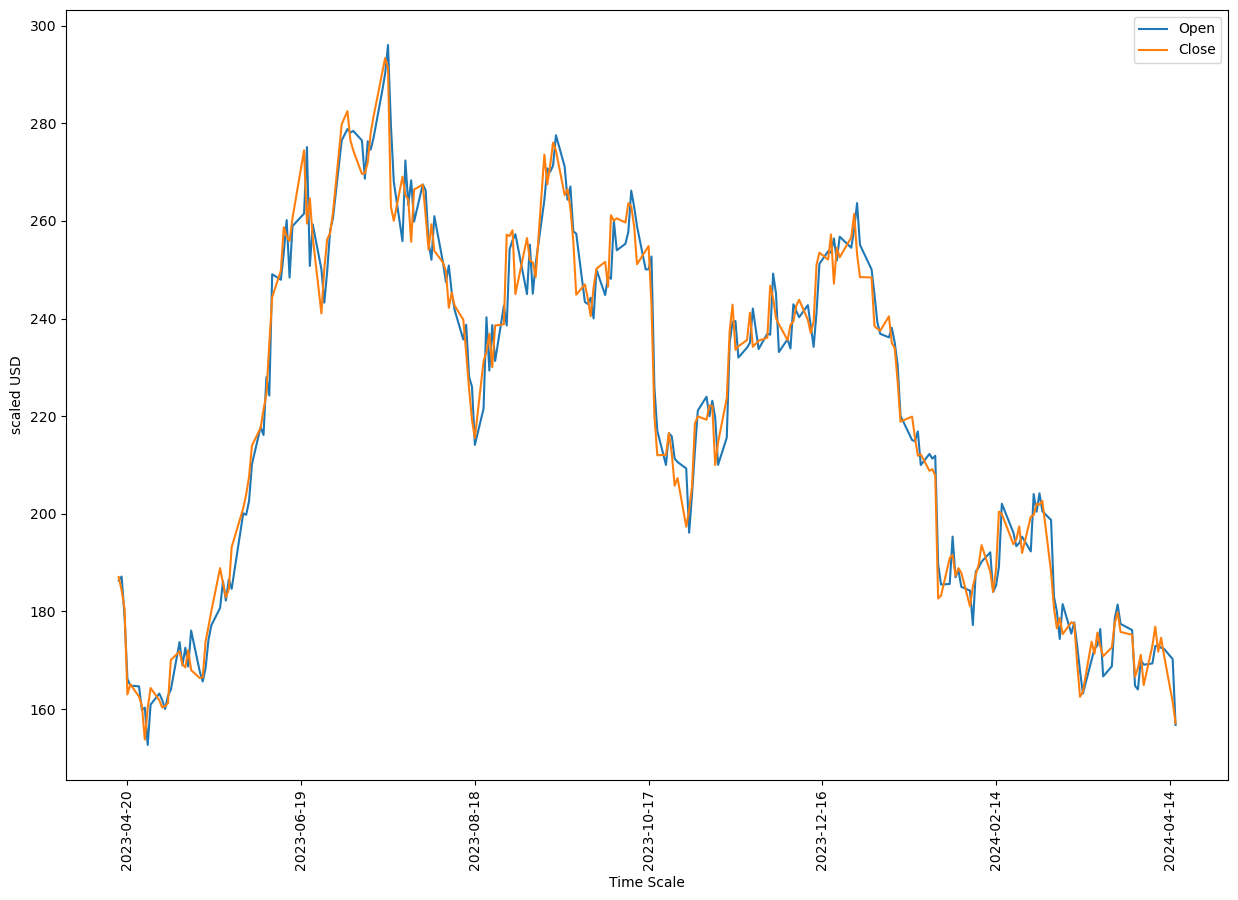

In [47]:
plot_init_graph (tsla_data, features = ['Open', 'Close'])

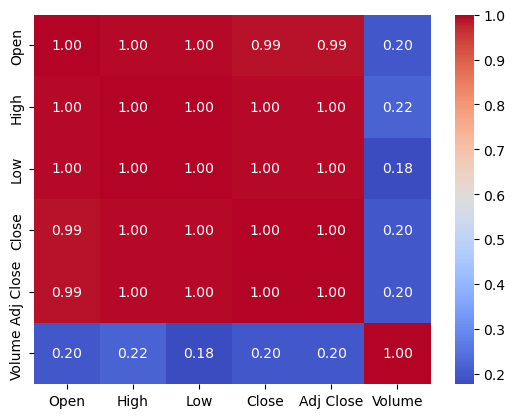

In [48]:
tsla_correlation_matrix = tsla_data.corr()
sns.heatmap(tsla_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Actual feature data shape  : (492, 10, 2)
Actual target data shape   : (492,)
Training feature data shape: (394, 10, 2)
Training target data shape : (394,)
Testing feature data shape : (98, 10, 2)
Testing target data shape  : (98,)
LSTM Summary: 


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
99/99 - 3s - 33ms/step - loss: 0.2532
Epoch 2/50
99/99 - 1s - 7ms/step - loss: 0.0223
Epoch 3/50
99/99 - 1s - 7ms/step - loss: 0.0238
Epoch 4/50
99/99 - 1s - 7ms/step - loss: 0.0153
Epoch 5/50
99/99 - 1s - 6ms/step - loss: 0.0116
Epoch 6/50
99/99 - 1s - 7ms/step - loss: 0.0099
Epoch 7/50
99/99 - 1s - 6ms/step - loss: 0.0102
Epoch 8/50
99/99 - 1s - 8ms/step - loss: 0.0093
Epoch 9/50
99/99 - 0s - 4ms/step - loss: 0.0081
Epoch 10/50
99/99 - 1s - 7ms/step - loss: 0.0070
Epoch 11/50
99/99 - 0s - 4ms/step - loss: 0.0061
Epoch 12/50
99/99 - 1s - 7ms/step - loss: 0.0054
Epoch 13/50
99/99 - 0s - 5ms/step - loss: 0.0048
Epoch 14/50
99/99 - 1s - 7ms/step - loss: 0.0042
Epoch 15/50
99/99 - 1s - 7ms/step - loss: 0.0037
Epoch 16/50
99/99 - 0s - 4ms/step - loss: 0.0031
Epoch 17/50
99/99 - 1s - 8ms/step - loss: 0.0027
Epoch 18/50
99/99 - 1s - 7ms/step - loss: 0.0024
Epoch 19/50
99/99 - 1s - 7ms/step - loss: 0.0023
Epoch 20/50
99/99 - 1s - 5ms/step - loss: 0.0021
Epoch 21/50
99/99 - 1s 

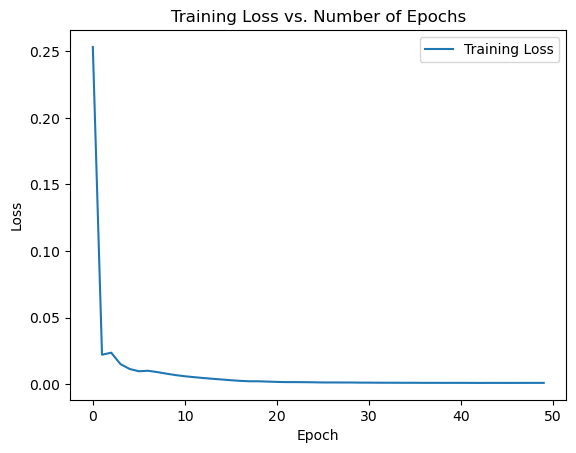

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
RSME : 0.19016383942711595
MAPE : 0.09052695674119751


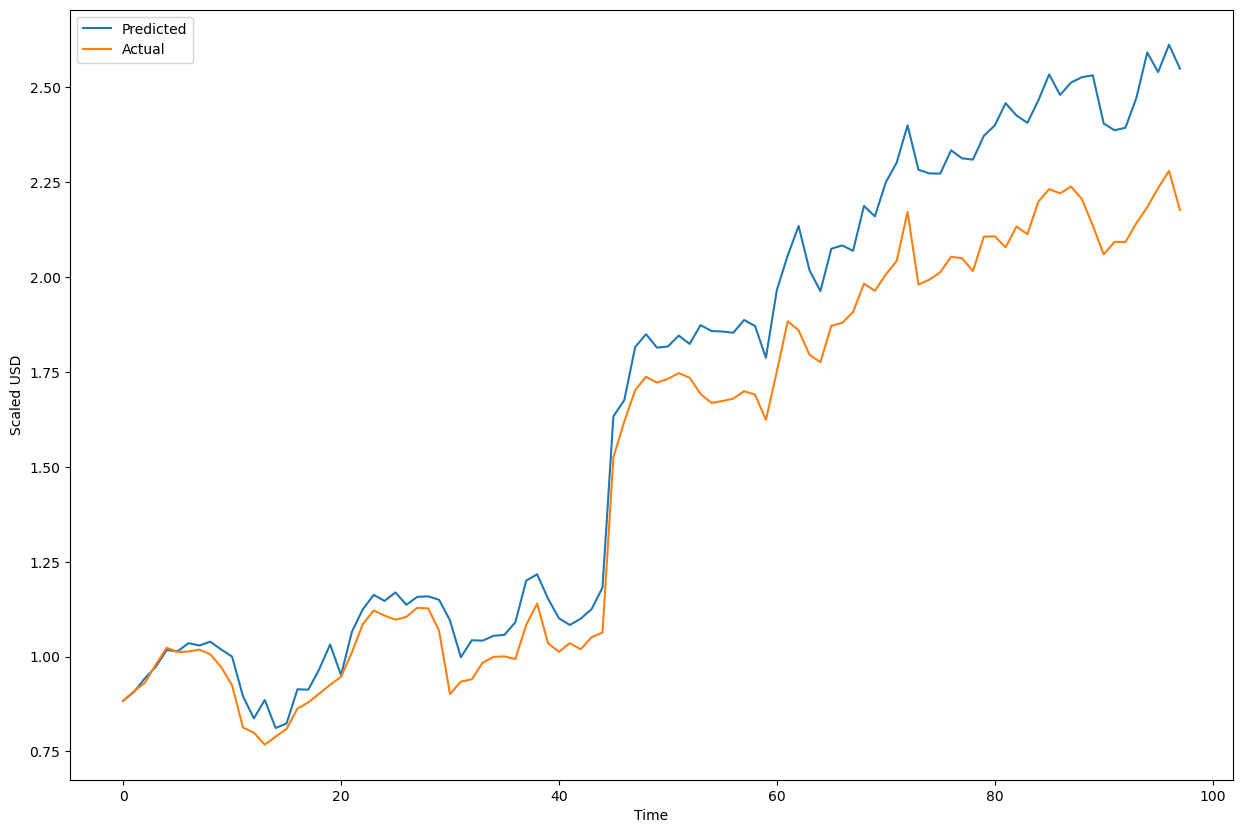

In [49]:
tsl_lstm, tsl_y_pred, tsl_y_test = predict_using_lstm(tsla_data, n_steps = 10)
plot_predicted_vs_actual (tsl_y_pred, tsl_y_test)

Actual feature data shape  : (500, 2, 2)
Actual target data shape   : (500,)
Training feature data shape: (400, 2, 2)
Training target data shape : (400,)
Testing feature data shape : (100, 2, 2)
Testing target data shape  : (100,)
LSTM Summary: 


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
100/100 - 2s - 24ms/step - loss: 0.6586
Epoch 2/50
100/100 - 0s - 2ms/step - loss: 0.2866
Epoch 3/50
100/100 - 0s - 4ms/step - loss: 0.0147
Epoch 4/50
100/100 - 0s - 3ms/step - loss: 0.0045
Epoch 5/50
100/100 - 0s - 3ms/step - loss: 0.0042
Epoch 6/50
100/100 - 0s - 4ms/step - loss: 0.0036
Epoch 7/50
100/100 - 0s - 3ms/step - loss: 0.0035
Epoch 8/50
100/100 - 0s - 4ms/step - loss: 0.0034
Epoch 9/50
100/100 - 0s - 3ms/step - loss: 0.0032
Epoch 10/50
100/100 - 0s - 3ms/step - loss: 0.0031
Epoch 11/50
100/100 - 0s - 3ms/step - loss: 0.0031
Epoch 12/50
100/100 - 0s - 3ms/step - loss: 0.0030
Epoch 13/50
100/100 - 0s - 3ms/step - loss: 0.0029
Epoch 14/50
100/100 - 0s - 3ms/step - loss: 0.0028
Epoch 15/50
100/100 - 0s - 4ms/step - loss: 0.0027
Epoch 16/50
100/100 - 0s - 3ms/step - loss: 0.0026
Epoch 17/50
100/100 - 0s - 3ms/step - loss: 0.0025
Epoch 18/50
100/100 - 0s - 3ms/step - loss: 0.0025
Epoch 19/50
100/100 - 0s - 3ms/step - loss: 0.0024
Epoch 20/50
100/100 - 0s - 3ms/ste

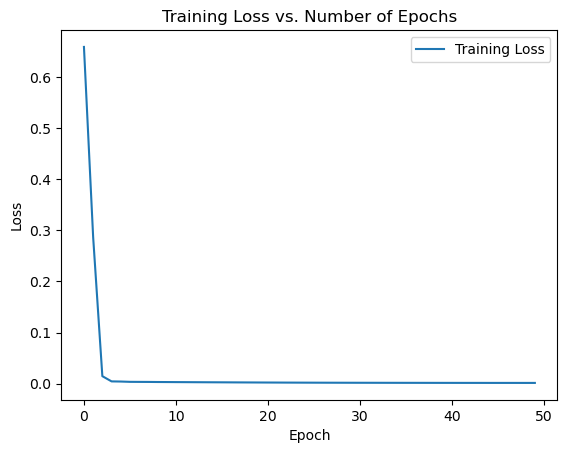

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
RSME : 0.2643030760531285
MAPE : 0.10958139546376816


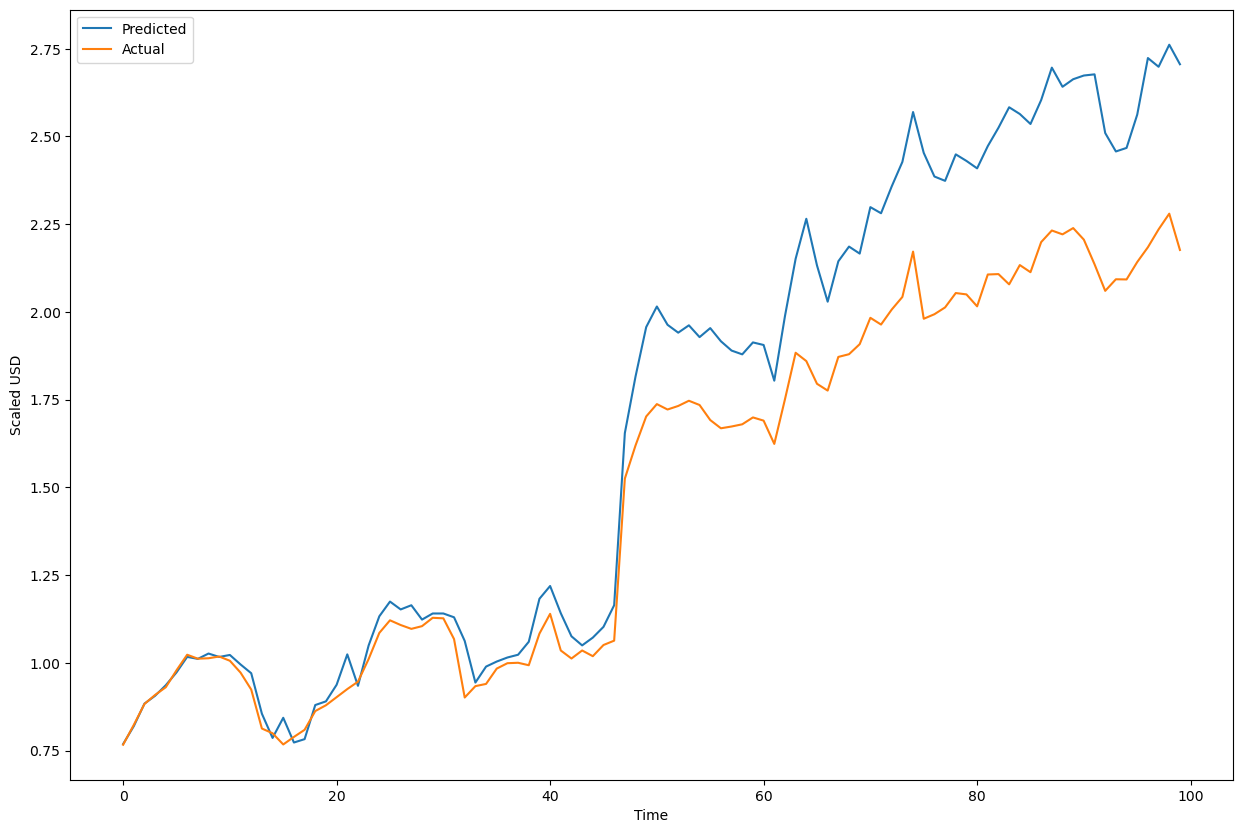

In [50]:
tsl_lstm1, tsl_y_pred1, tsl_y_test1 = predict_using_lstm(tsla_data)
plot_predicted_vs_actual (tsl_y_pred1, tsl_y_test1)

### EMA

Test RMSE: 17.851
Test MAPE: 0.088


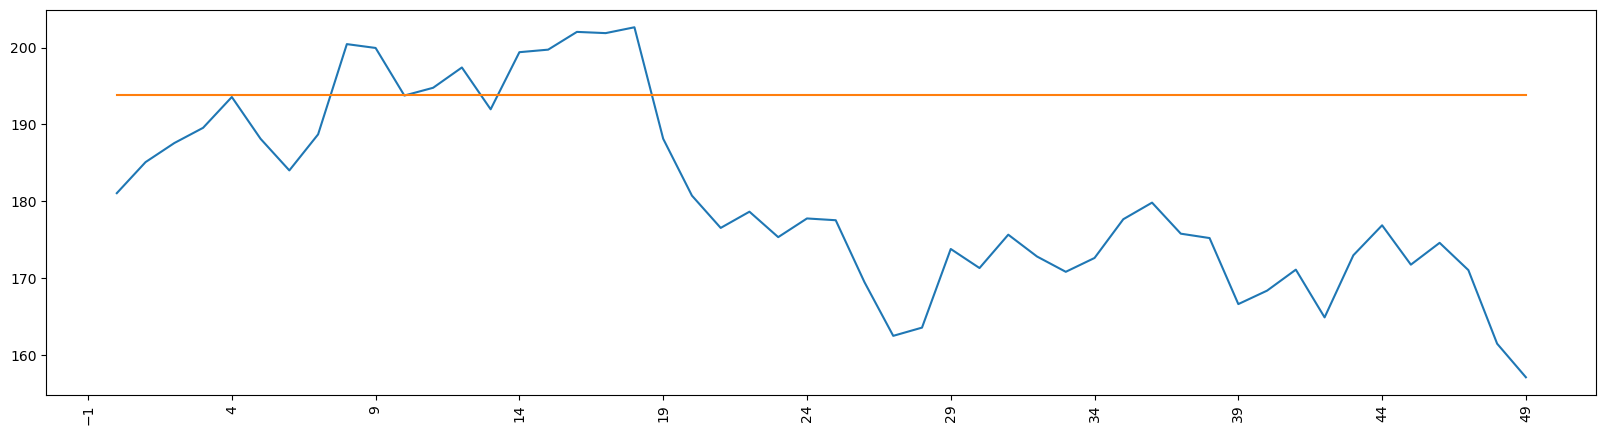

In [51]:
predict_using_ema (tsla_data)

# SMA

Test RMSE: 17.847
Test MAPE: 0.088


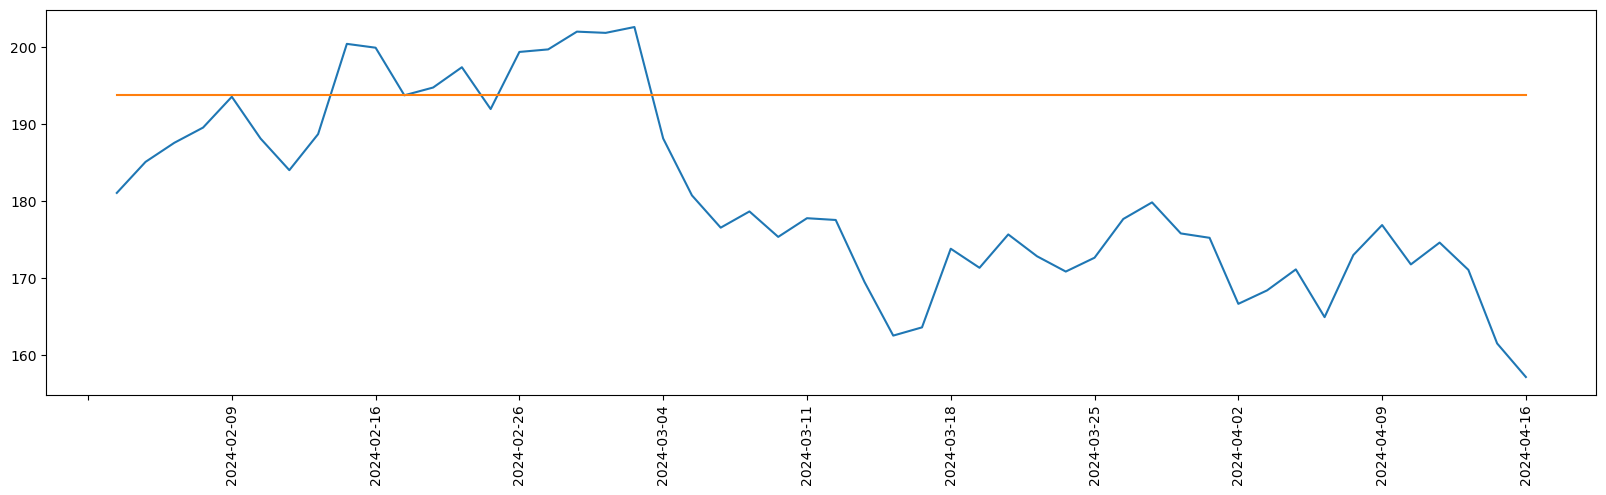

In [52]:
predict_using_sma (tsla_data)

# LSTM with last 3 months data

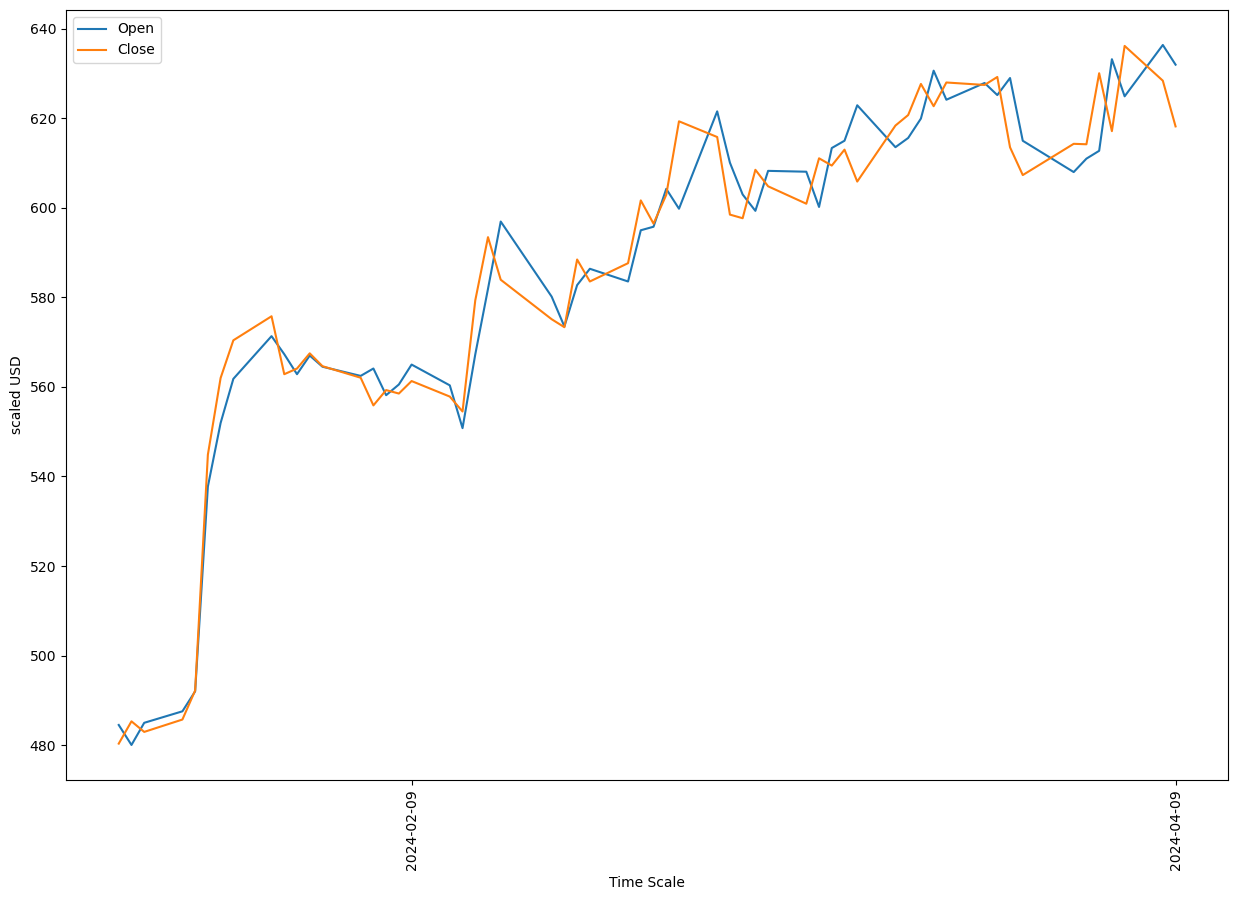

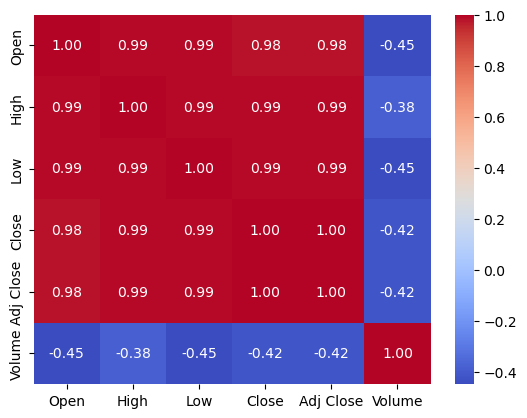

Actual feature data shape  : (500, 2, 2)
Actual target data shape   : (500,)
Training feature data shape: (400, 2, 2)
Training target data shape : (400,)
Testing feature data shape : (100, 2, 2)
Testing target data shape  : (100,)
LSTM Summary: 


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
100/100 - 2s - 23ms/step - loss: 0.4819
Epoch 2/50
100/100 - 0s - 4ms/step - loss: 0.1196
Epoch 3/50
100/100 - 0s - 3ms/step - loss: 0.0036
Epoch 4/50
100/100 - 0s - 4ms/step - loss: 0.0033
Epoch 5/50
100/100 - 0s - 3ms/step - loss: 0.0030
Epoch 6/50
100/100 - 0s - 4ms/step - loss: 0.0029
Epoch 7/50
100/100 - 0s - 4ms/step - loss: 0.0028
Epoch 8/50
100/100 - 0s - 3ms/step - loss: 0.0027
Epoch 9/50
100/100 - 0s - 3ms/step - loss: 0.0026
Epoch 10/50
100/100 - 0s - 3ms/step - loss: 0.0025
Epoch 11/50
100/100 - 0s - 4ms/step - loss: 0.0025
Epoch 12/50
100/100 - 0s - 4ms/step - loss: 0.0024
Epoch 13/50
100/100 - 0s - 3ms/step - loss: 0.0023
Epoch 14/50
100/100 - 0s - 3ms/step - loss: 0.0023
Epoch 15/50
100/100 - 0s - 3ms/step - loss: 0.0023
Epoch 16/50
100/100 - 0s - 3ms/step - loss: 0.0022
Epoch 17/50
100/100 - 0s - 3ms/step - loss: 0.0022
Epoch 18/50
100/100 - 0s - 3ms/step - loss: 0.0021
Epoch 19/50
100/100 - 0s - 4ms/step - loss: 0.0021
Epoch 20/50
100/100 - 0s - 4ms/ste

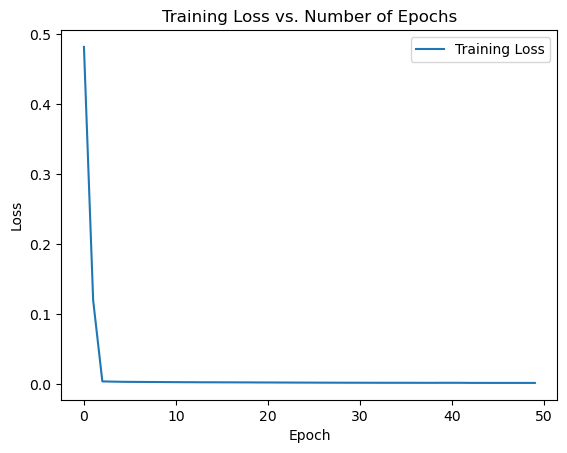

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
RSME : 0.1878677655875338
MAPE : 0.08126804383692177


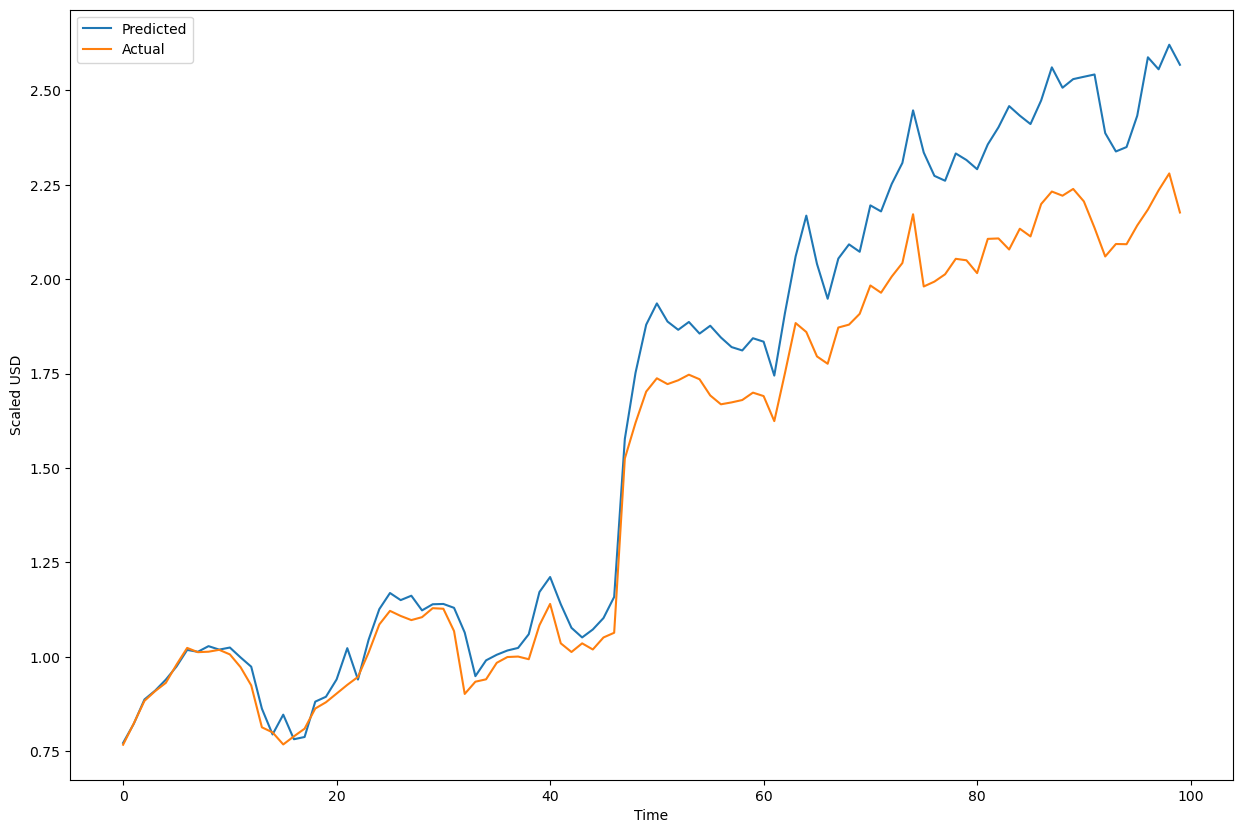

In [53]:
nfx_3m_data = pd.read_csv('./NFLX_3m.csv', index_col='Date')
plot_init_graph (nfx_3m_data, features = ['Open', 'Close'])
nfx_3m_data_correlation_matrix = nfx_3m_data.corr()
sns.heatmap(nfx_3m_data_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()
nfx_3m_lstm, nfx_3m_y_pred, nfx_3m_y_test = predict_using_lstm(nfx_3m_data)
plot_predicted_vs_actual (nfx_3m_y_pred, nfx_3m_y_test)

Test RMSE: 9.199
Test MAPE: 0.012


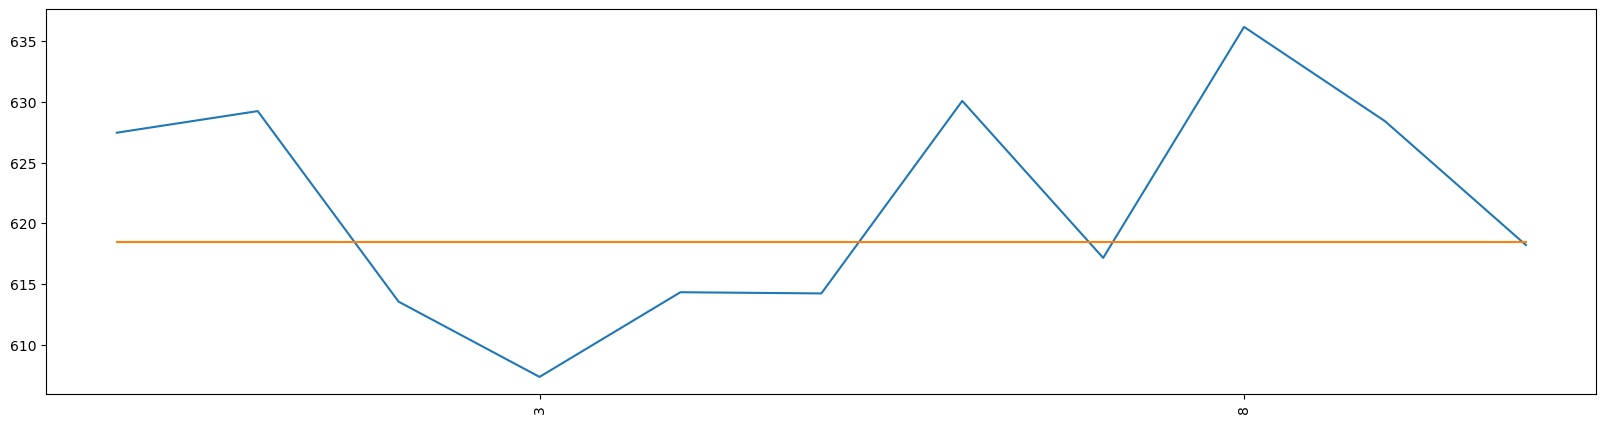

In [54]:
predict_using_ema (nfx_3m_data)

Test RMSE: 10.381
Test MAPE: 0.013


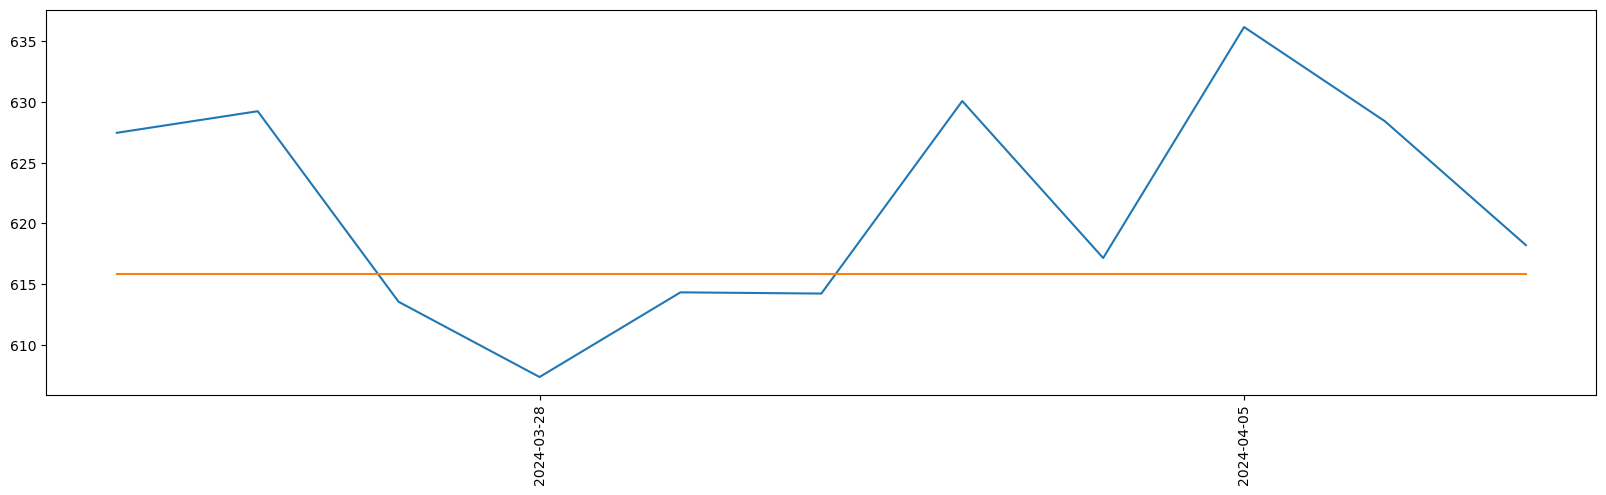

In [55]:
predict_using_sma (nfx_3m_data)

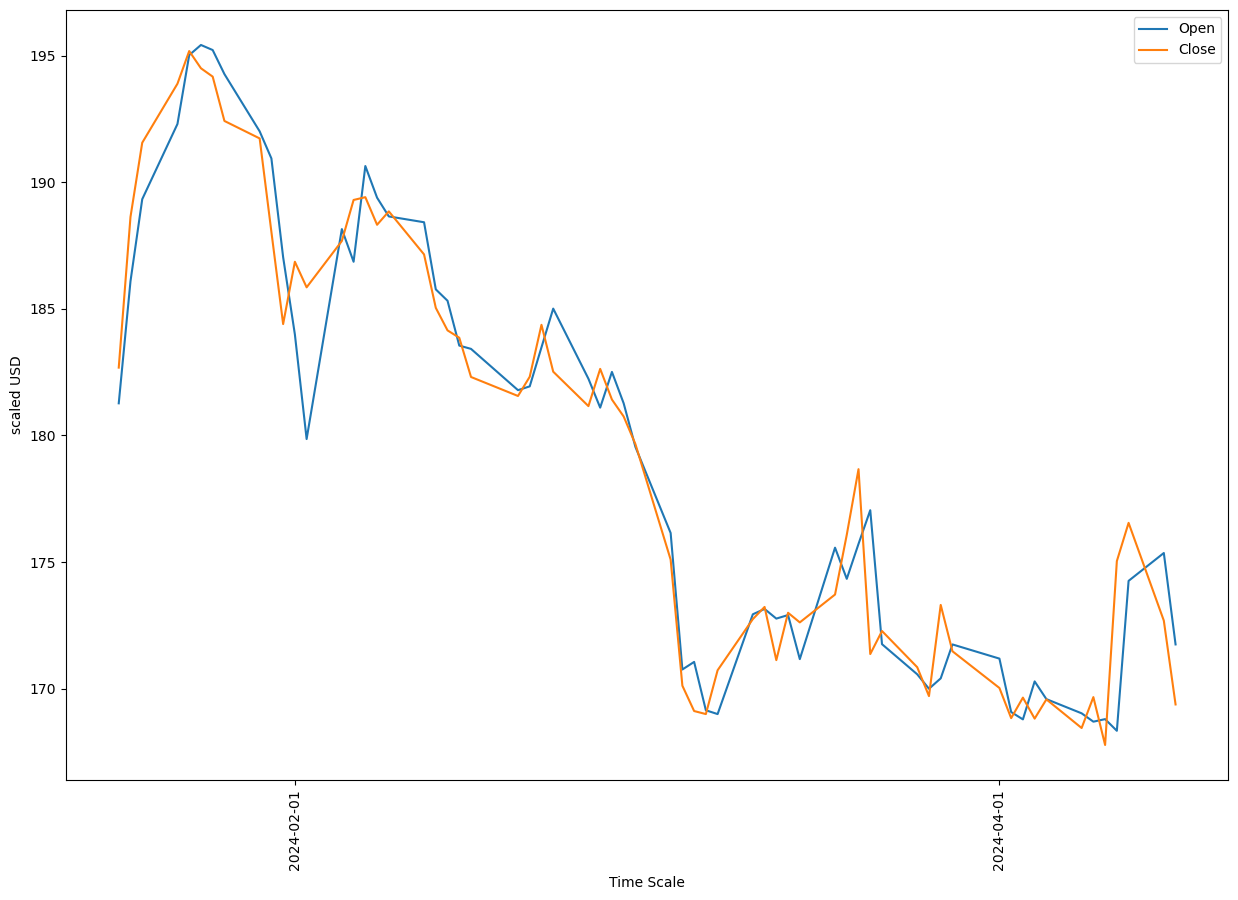

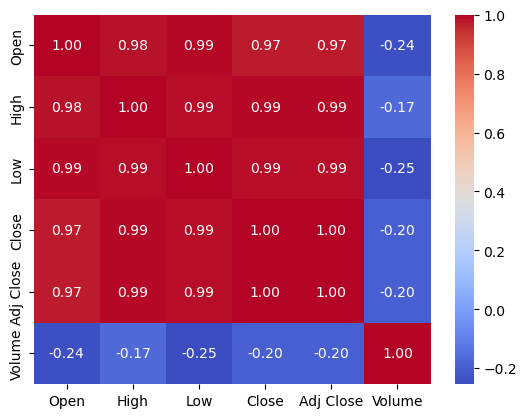

Actual feature data shape  : (500, 2, 2)
Actual target data shape   : (500,)
Training feature data shape: (400, 2, 2)
Training target data shape : (400,)
Testing feature data shape : (100, 2, 2)
Testing target data shape  : (100,)
LSTM Summary: 


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
100/100 - 2s - 22ms/step - loss: 0.5111
Epoch 2/50
100/100 - 0s - 3ms/step - loss: 0.1855
Epoch 3/50
100/100 - 0s - 4ms/step - loss: 0.0074
Epoch 4/50
100/100 - 0s - 3ms/step - loss: 0.0038
Epoch 5/50
100/100 - 0s - 3ms/step - loss: 0.0036
Epoch 6/50
100/100 - 0s - 3ms/step - loss: 0.0035
Epoch 7/50
100/100 - 0s - 4ms/step - loss: 0.0034
Epoch 8/50
100/100 - 0s - 3ms/step - loss: 0.0033
Epoch 9/50
100/100 - 0s - 4ms/step - loss: 0.0032
Epoch 10/50
100/100 - 0s - 3ms/step - loss: 0.0031
Epoch 11/50
100/100 - 0s - 2ms/step - loss: 0.0031
Epoch 12/50
100/100 - 0s - 4ms/step - loss: 0.0030
Epoch 13/50
100/100 - 0s - 3ms/step - loss: 0.0029
Epoch 14/50
100/100 - 0s - 4ms/step - loss: 0.0028
Epoch 15/50
100/100 - 0s - 3ms/step - loss: 0.0028
Epoch 16/50
100/100 - 0s - 3ms/step - loss: 0.0027
Epoch 17/50
100/100 - 0s - 3ms/step - loss: 0.0026
Epoch 18/50
100/100 - 0s - 4ms/step - loss: 0.0025
Epoch 19/50
100/100 - 0s - 2ms/step - loss: 0.0024
Epoch 20/50
100/100 - 0s - 3ms/ste

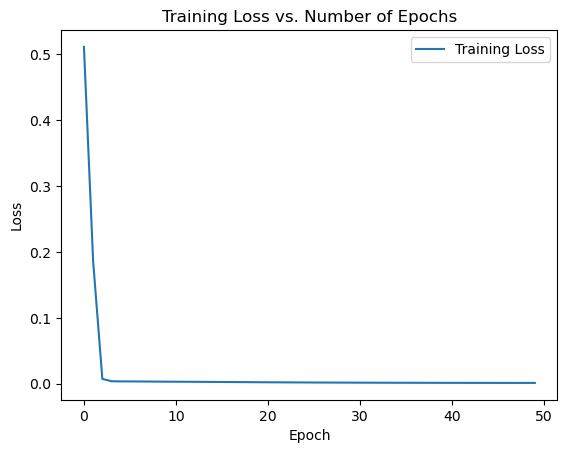

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
RSME : 0.1998422555731686
MAPE : 0.08705630508356321


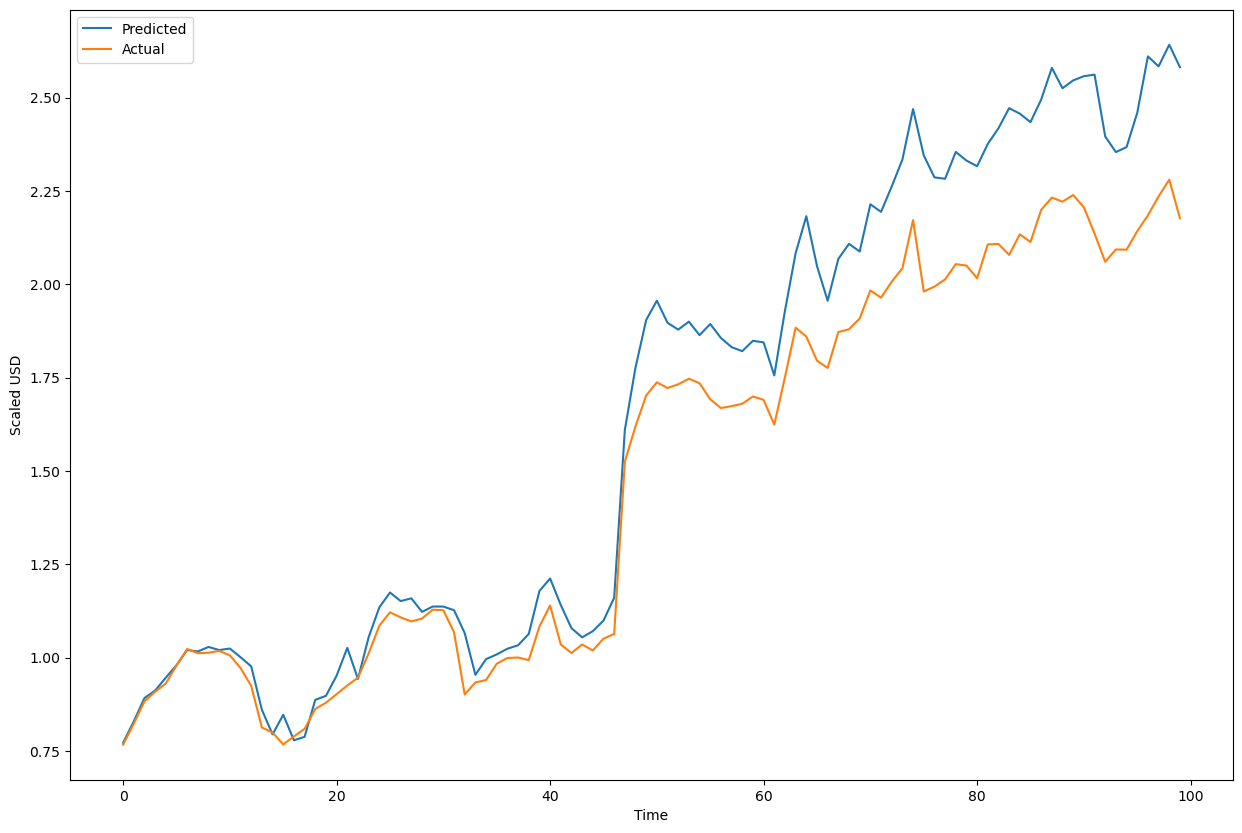

In [56]:
apl_3m_data = pd.read_csv('./AAPL_3m.csv', index_col='Date')
plot_init_graph (apl_3m_data, features = ['Open', 'Close'])
apl_3m_data_correlation_matrix = apl_3m_data.corr()
sns.heatmap(apl_3m_data_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()
apl_3m_lstm, apl_3m_y_pred, apl_3m_y_test = predict_using_lstm(apl_3m_data)
plot_predicted_vs_actual (apl_3m_y_pred, apl_3m_y_test)

Test RMSE: 3.220
Test MAPE: 0.018


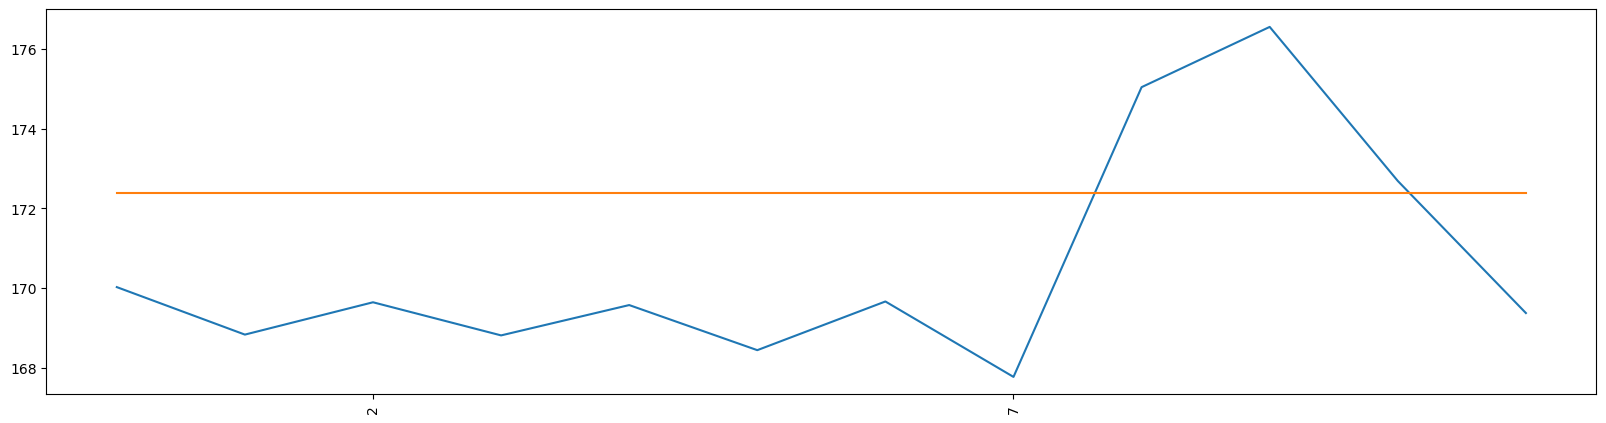

In [57]:
predict_using_ema (apl_3m_data)

Test RMSE: 3.606
Test MAPE: 0.020


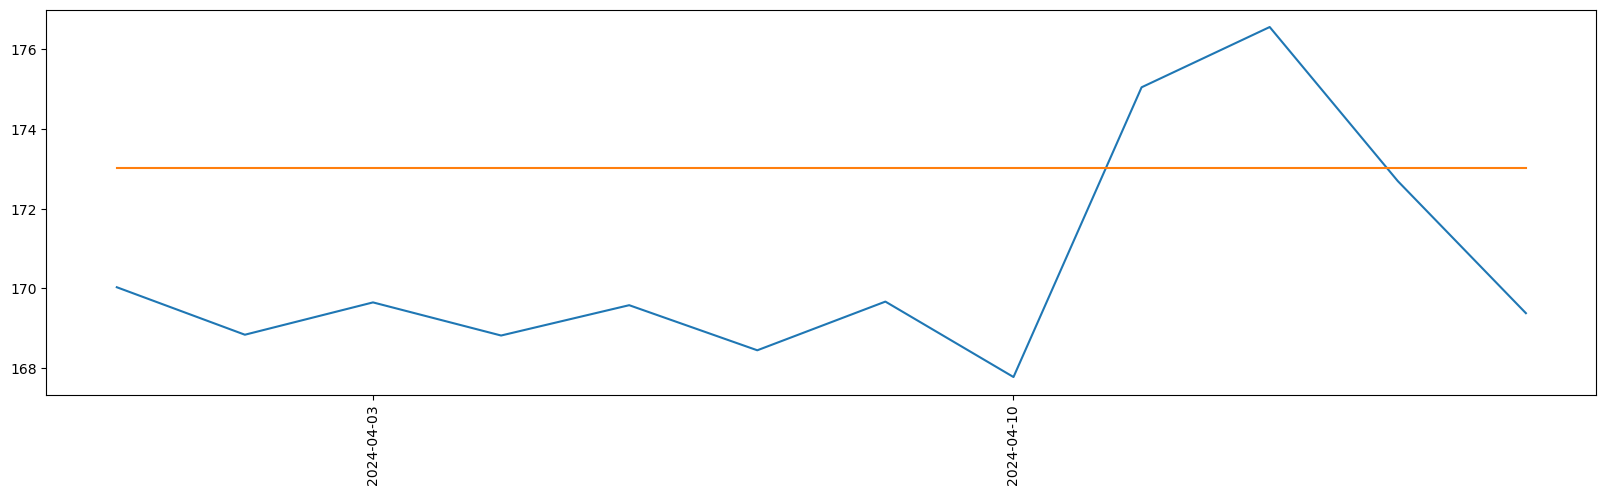

In [58]:
predict_using_sma (apl_3m_data)

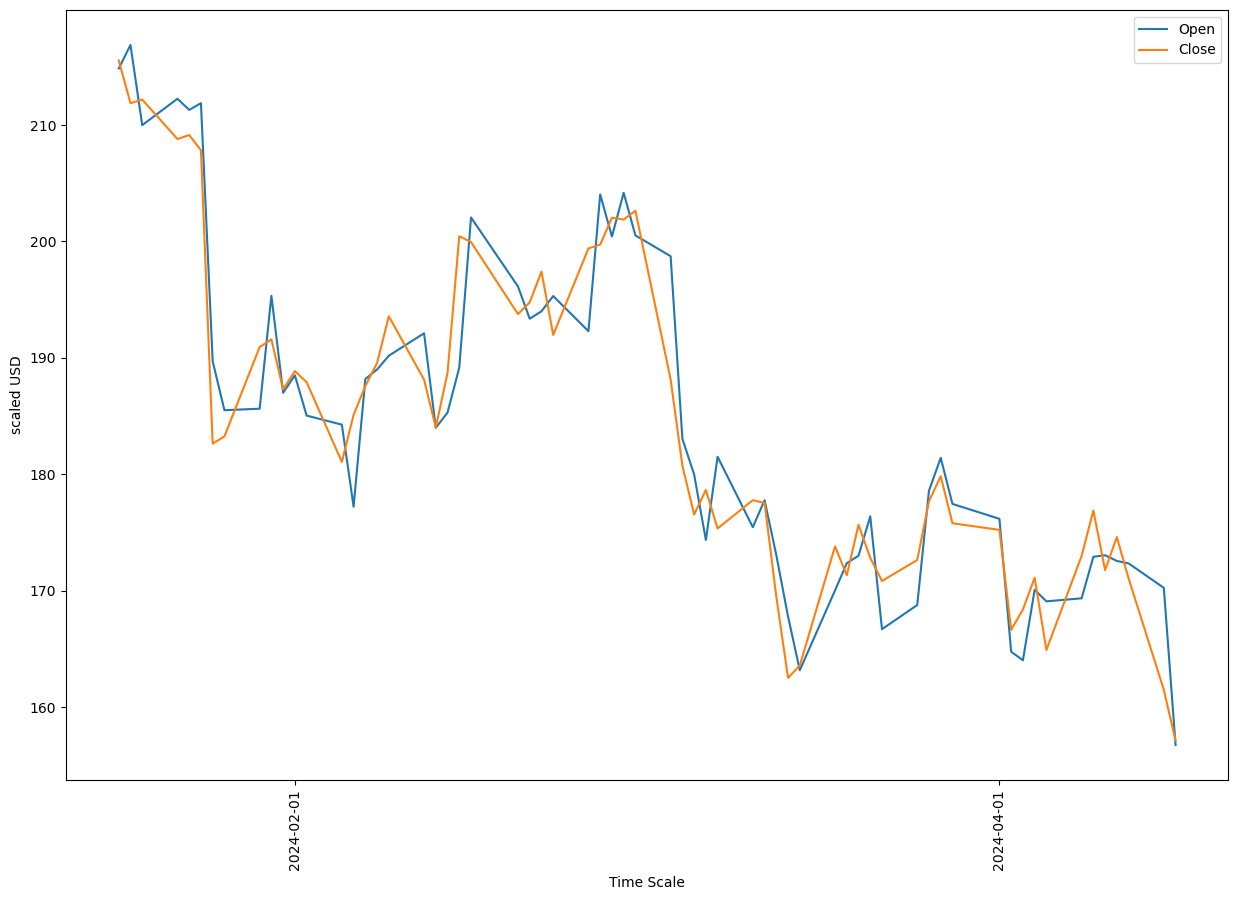

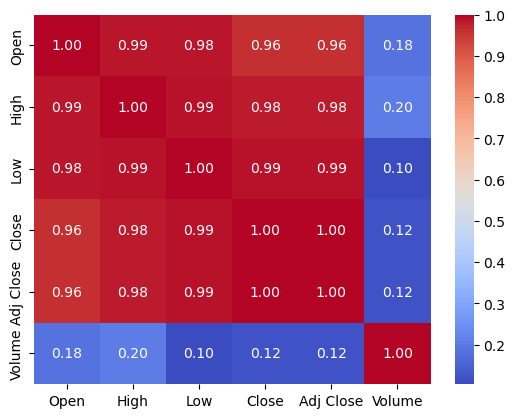

Actual feature data shape  : (500, 2, 2)
Actual target data shape   : (500,)
Training feature data shape: (400, 2, 2)
Training target data shape : (400,)
Testing feature data shape : (100, 2, 2)
Testing target data shape  : (100,)
LSTM Summary: 


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
100/100 - 3s - 28ms/step - loss: 0.3863
Epoch 2/50
100/100 - 0s - 3ms/step - loss: 0.0660
Epoch 3/50
100/100 - 0s - 3ms/step - loss: 0.0035
Epoch 4/50
100/100 - 0s - 3ms/step - loss: 0.0033
Epoch 5/50
100/100 - 0s - 4ms/step - loss: 0.0031
Epoch 6/50
100/100 - 0s - 3ms/step - loss: 0.0029
Epoch 7/50
100/100 - 0s - 3ms/step - loss: 0.0028
Epoch 8/50
100/100 - 0s - 4ms/step - loss: 0.0027
Epoch 9/50
100/100 - 0s - 3ms/step - loss: 0.0025
Epoch 10/50
100/100 - 0s - 3ms/step - loss: 0.0024
Epoch 11/50
100/100 - 0s - 3ms/step - loss: 0.0024
Epoch 12/50
100/100 - 0s - 3ms/step - loss: 0.0023
Epoch 13/50
100/100 - 0s - 4ms/step - loss: 0.0023
Epoch 14/50
100/100 - 0s - 3ms/step - loss: 0.0023
Epoch 15/50
100/100 - 0s - 4ms/step - loss: 0.0022
Epoch 16/50
100/100 - 0s - 3ms/step - loss: 0.0022
Epoch 17/50
100/100 - 0s - 2ms/step - loss: 0.0022
Epoch 18/50
100/100 - 0s - 4ms/step - loss: 0.0021
Epoch 19/50
100/100 - 0s - 4ms/step - loss: 0.0020
Epoch 20/50
100/100 - 0s - 3ms/ste

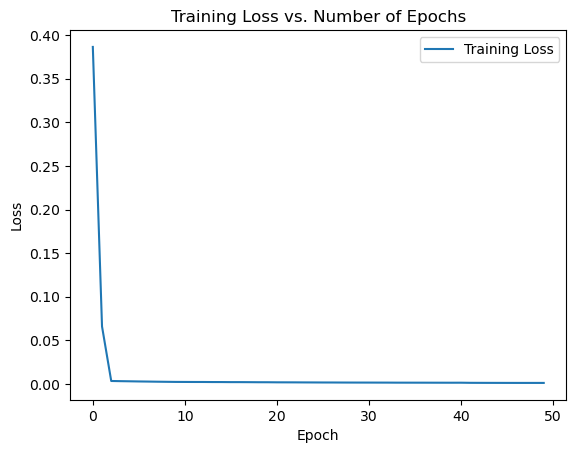

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
RSME : 0.13148957181851012
MAPE : 0.057467760537115664


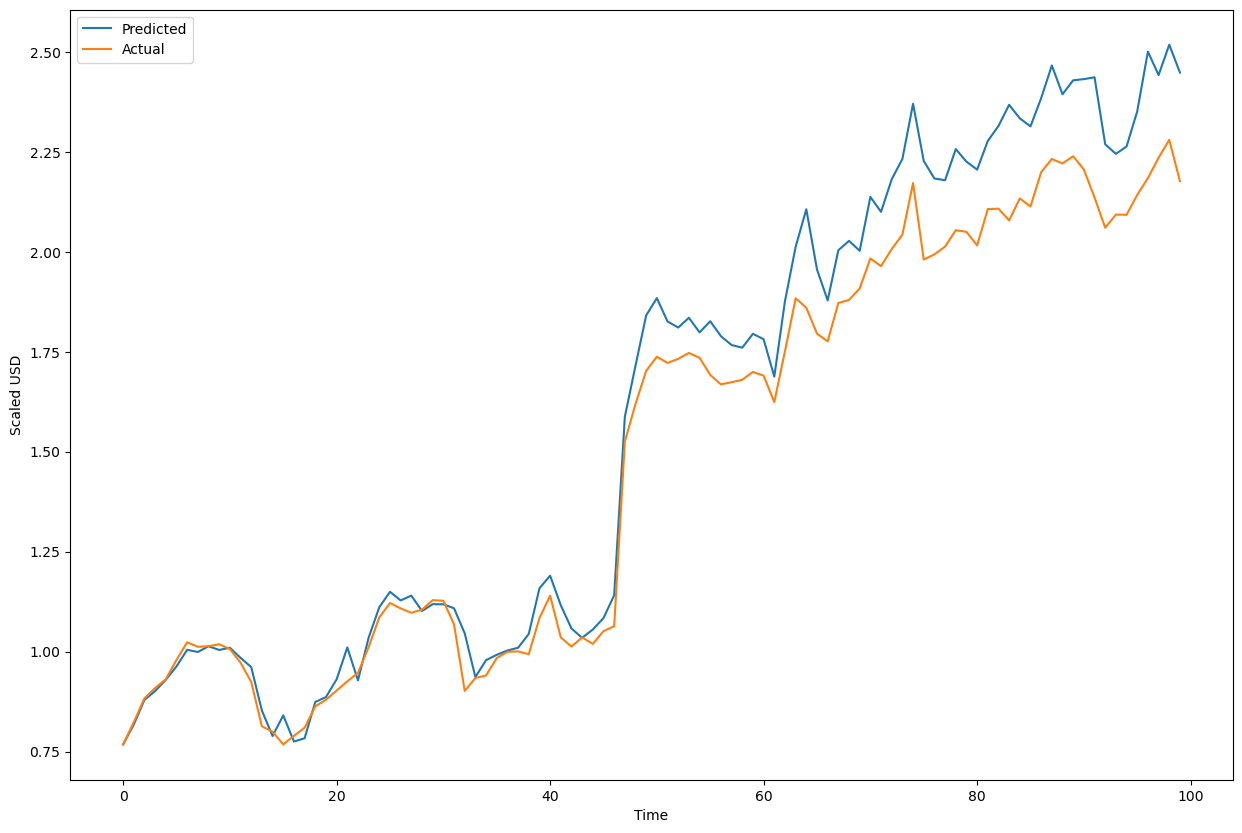

In [59]:
tsl_3m_data = pd.read_csv('./TSLA_3m.csv', index_col='Date')
plot_init_graph (tsl_3m_data, features = ['Open', 'Close'])
tsl_3m_data_correlation_matrix = tsl_3m_data.corr()
sns.heatmap(tsl_3m_data_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()
tsl_3m_lstm, tsl_3m_y_pred, tsl_3m_y_test = predict_using_lstm(tsl_3m_data)
plot_predicted_vs_actual (tsl_3m_y_pred, tsl_3m_y_test)

Test RMSE: 8.168
Test MAPE: 0.038


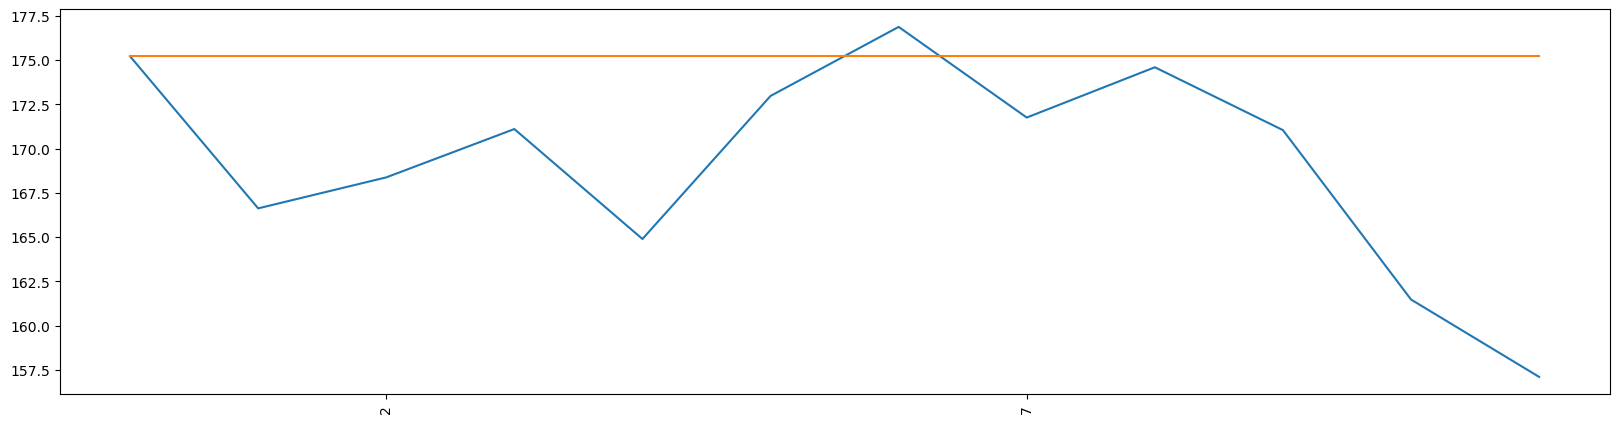

In [60]:
predict_using_ema (tsl_3m_data)

Test RMSE: 6.955
Test MAPE: 0.031


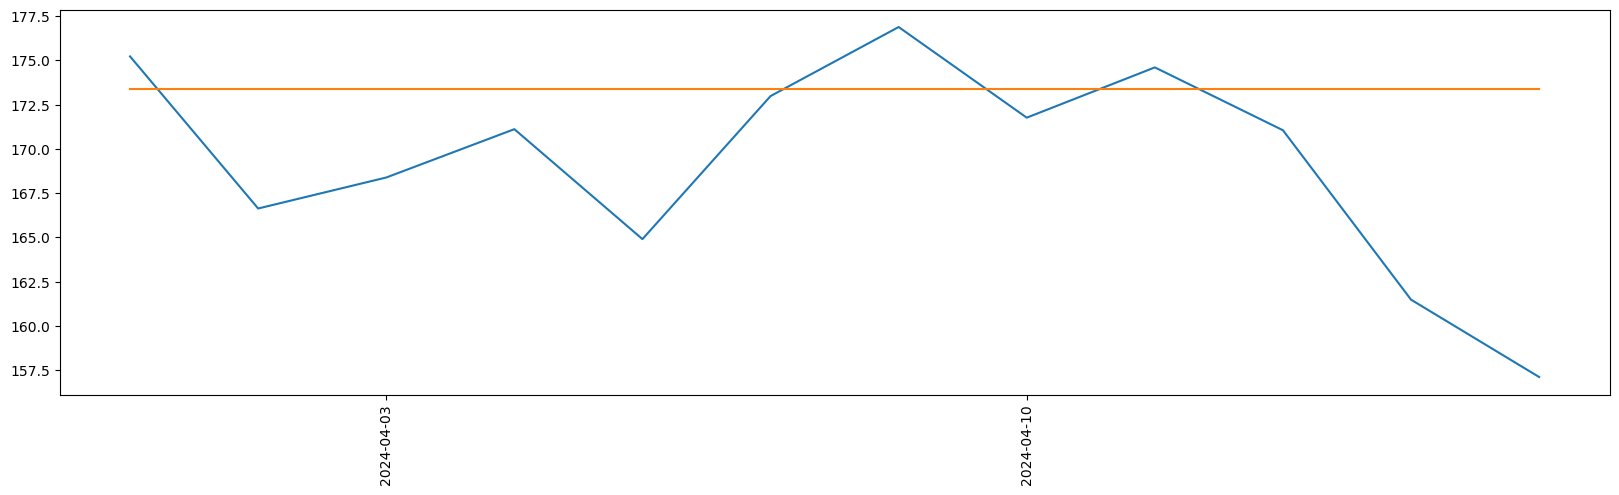

In [61]:
predict_using_sma (tsl_3m_data)

# Affect of corona

Actual feature data shape  : (492, 10, 2)
Actual target data shape   : (492,)
Training feature data shape: (246, 10, 2)
Training target data shape : (246,)
Testing feature data shape : (246, 10, 2)
Testing target data shape  : (246,)
LSTM Summary: 


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
62/62 - 3s - 44ms/step - loss: 0.3238
Epoch 2/50
62/62 - 1s - 10ms/step - loss: 0.0233
Epoch 3/50
62/62 - 0s - 6ms/step - loss: 0.0149
Epoch 4/50
62/62 - 0s - 6ms/step - loss: 0.0112
Epoch 5/50
62/62 - 0s - 5ms/step - loss: 0.0093
Epoch 6/50
62/62 - 0s - 6ms/step - loss: 0.0074
Epoch 7/50
62/62 - 0s - 5ms/step - loss: 0.0060
Epoch 8/50
62/62 - 0s - 6ms/step - loss: 0.0049
Epoch 9/50
62/62 - 0s - 6ms/step - loss: 0.0046
Epoch 10/50
62/62 - 0s - 4ms/step - loss: 0.0044
Epoch 11/50
62/62 - 0s - 5ms/step - loss: 0.0040
Epoch 12/50
62/62 - 0s - 5ms/step - loss: 0.0036
Epoch 13/50
62/62 - 0s - 4ms/step - loss: 0.0033
Epoch 14/50
62/62 - 0s - 8ms/step - loss: 0.0031
Epoch 15/50
62/62 - 0s - 5ms/step - loss: 0.0028
Epoch 16/50
62/62 - 0s - 6ms/step - loss: 0.0026
Epoch 17/50
62/62 - 0s - 7ms/step - loss: 0.0024
Epoch 18/50
62/62 - 1s - 11ms/step - loss: 0.0023
Epoch 19/50
62/62 - 1s - 10ms/step - loss: 0.0021
Epoch 20/50
62/62 - 0s - 5ms/step - loss: 0.0020
Epoch 21/50
62/62 - 

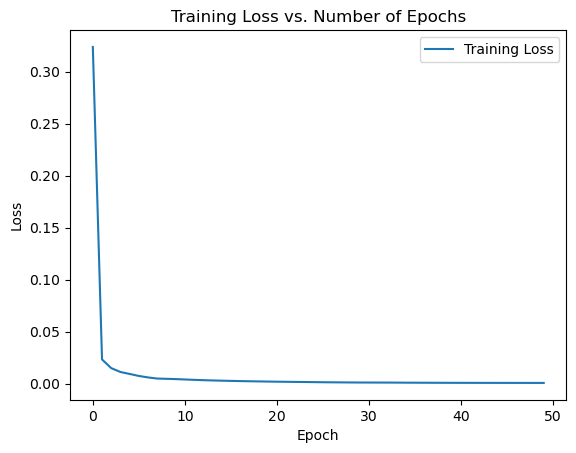

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
RSME : 3.958094275098769
MAPE : 1.3394765227070824


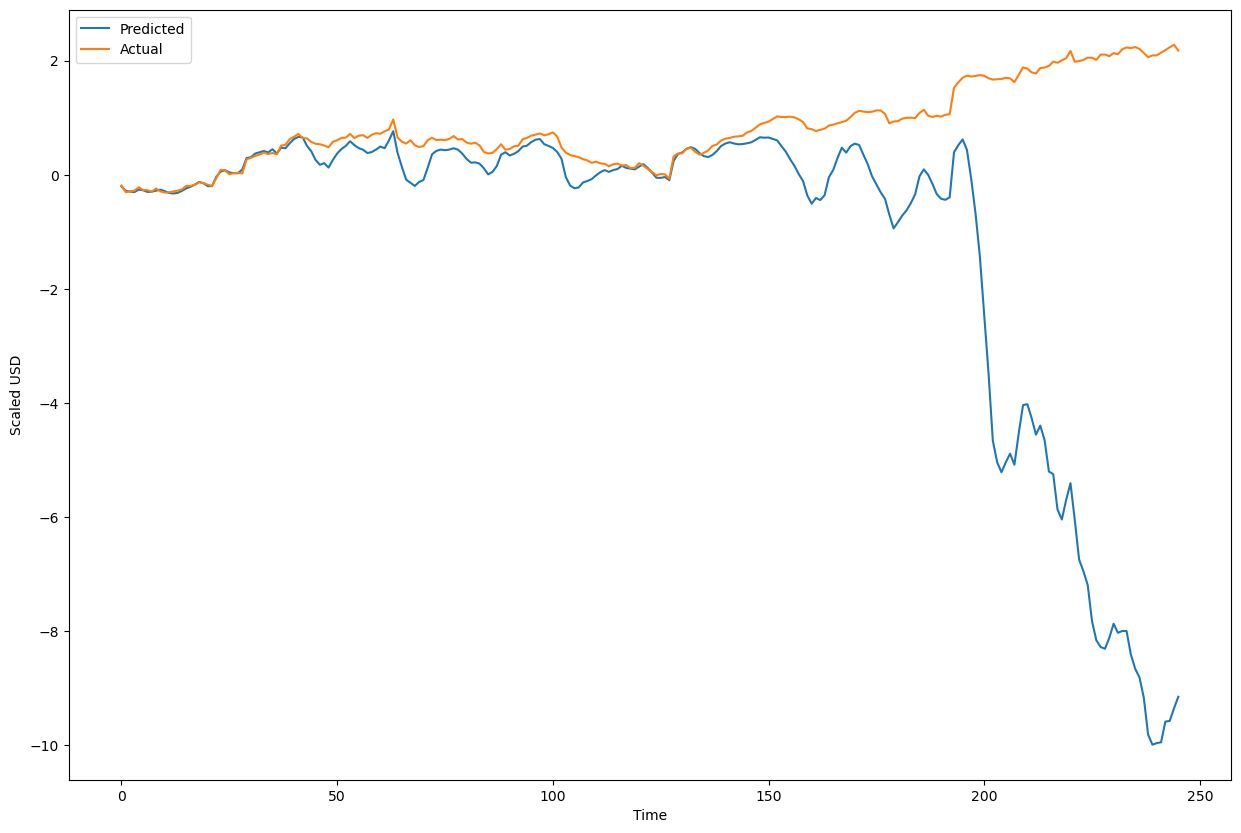

In [62]:
lstm5_2, y_pred5_2, y_test5_2 = predict_using_lstm(nflx_5_yrs_data, n_steps = 10, train_split=0.5)
plot_predicted_vs_actual (y_pred5_2, y_test5_2)

Test RMSE: 260.713
Test MAPE: 0.799


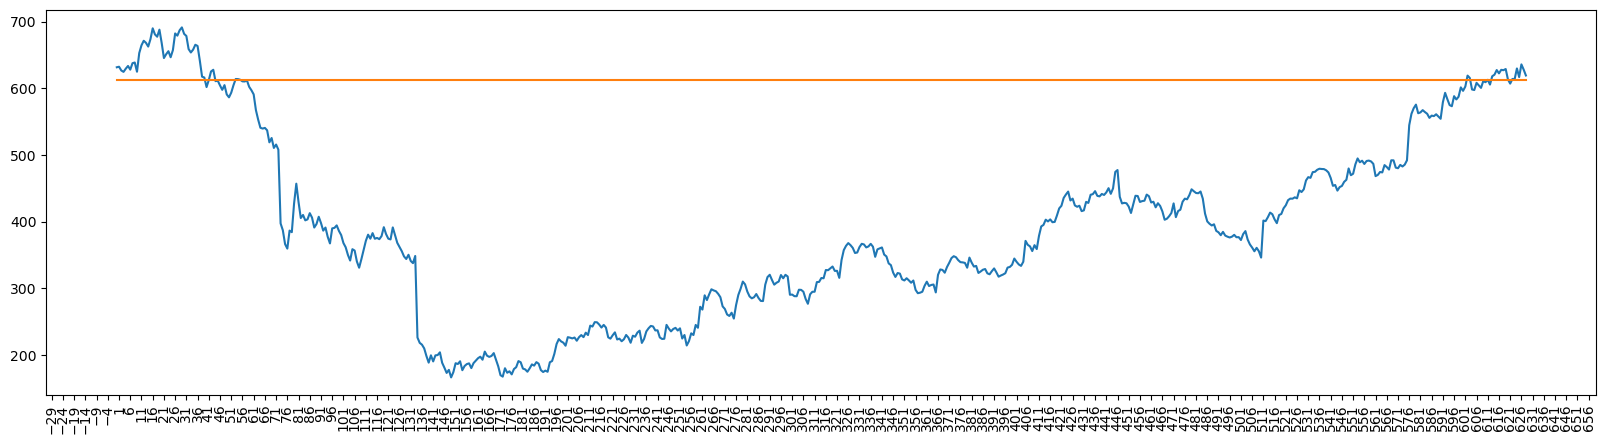

In [63]:
predict_using_ema (nflx_5_yrs_data, train_split=0.5)

Test RMSE: 255.281
Test MAPE: 0.783


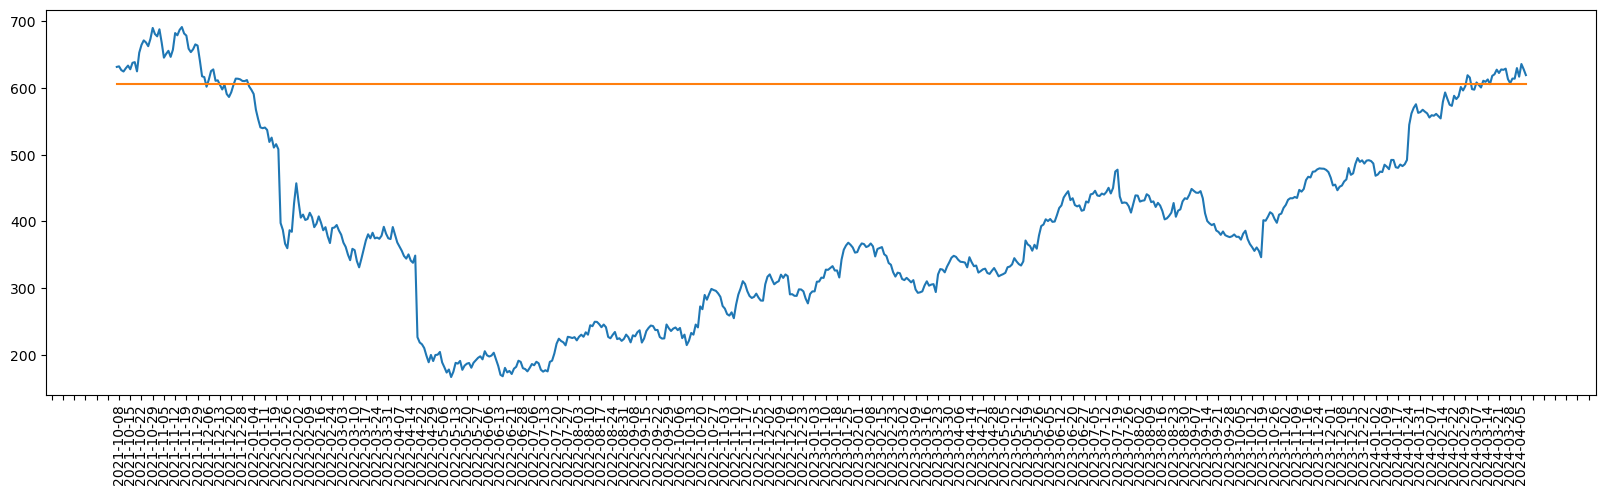

In [64]:
predict_using_sma (nflx_5_yrs_data, train_split=0.5)

# Different kind of dataset

In [65]:
smci_data = pd.read_csv('./SMCI.csv', index_col='Date')
smci_data.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-04-21  106.989998  108.070000  102.330002  107.320000  107.320000   
2023-04-24   97.510002  103.370003   96.910004   98.589996   98.589996   
2023-04-25   97.989998   97.989998   93.190002   93.279999   93.279999   
2023-04-26   94.639999   96.180000   94.010002   94.889999   94.889999   
2023-04-27   94.220001   98.760002   93.339996   98.580002   98.580002   

             Volume  
Date                 
2023-04-21  1098700  
2023-04-24  4235100  
2023-04-25  2171100  
2023-04-26  1504300  
2023-04-27  1000600

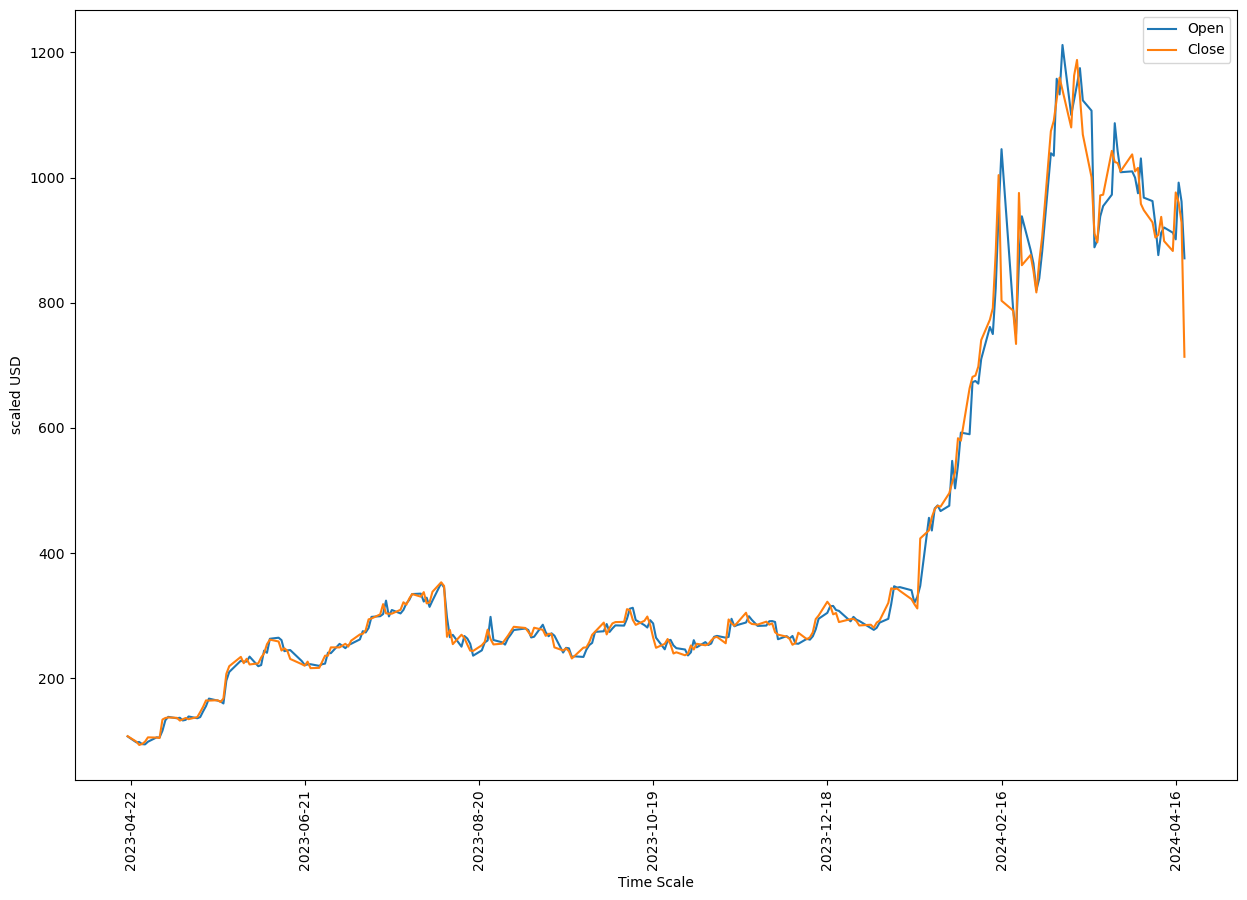

In [66]:
plot_init_graph (smci_data, features = ['Open', 'Close'])

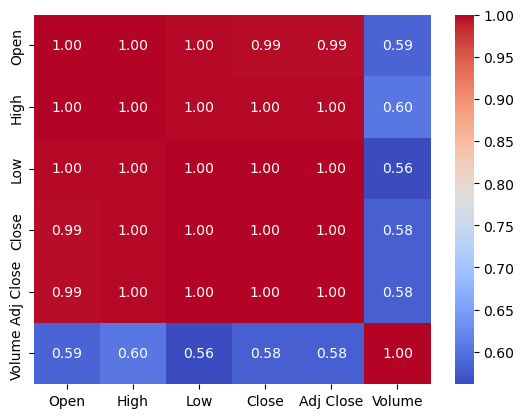

In [67]:
smci_correlation_matrix = smci_data.corr()
sns.heatmap(smci_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Actual feature data shape  : (500, 2, 2)
Actual target data shape   : (500,)
Training feature data shape: (400, 2, 2)
Training target data shape : (400,)
Testing feature data shape : (100, 2, 2)
Testing target data shape  : (100,)
LSTM Summary: 


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
100/100 - 3s - 26ms/step - loss: 0.3738
Epoch 2/50
100/100 - 0s - 3ms/step - loss: 0.0790
Epoch 3/50
100/100 - 0s - 3ms/step - loss: 0.0035
Epoch 4/50
100/100 - 0s - 4ms/step - loss: 0.0033
Epoch 5/50
100/100 - 0s - 3ms/step - loss: 0.0030
Epoch 6/50
100/100 - 0s - 3ms/step - loss: 0.0028
Epoch 7/50
100/100 - 0s - 3ms/step - loss: 0.0026
Epoch 8/50
100/100 - 0s - 4ms/step - loss: 0.0025
Epoch 9/50
100/100 - 0s - 3ms/step - loss: 0.0024
Epoch 10/50
100/100 - 0s - 2ms/step - loss: 0.0023
Epoch 11/50
100/100 - 0s - 3ms/step - loss: 0.0023
Epoch 12/50
100/100 - 0s - 4ms/step - loss: 0.0022
Epoch 13/50
100/100 - 0s - 3ms/step - loss: 0.0021
Epoch 14/50
100/100 - 0s - 4ms/step - loss: 0.0020
Epoch 15/50
100/100 - 0s - 3ms/step - loss: 0.0020
Epoch 16/50
100/100 - 0s - 3ms/step - loss: 0.0019
Epoch 17/50
100/100 - 0s - 4ms/step - loss: 0.0019
Epoch 18/50
100/100 - 1s - 6ms/step - loss: 0.0018
Epoch 19/50
100/100 - 0s - 3ms/step - loss: 0.0018
Epoch 20/50
100/100 - 0s - 4ms/ste

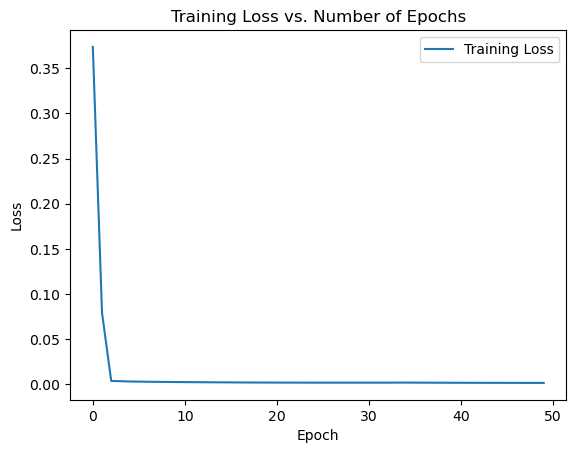

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
RSME : 0.194770822508574
MAPE : 0.08057159940724658


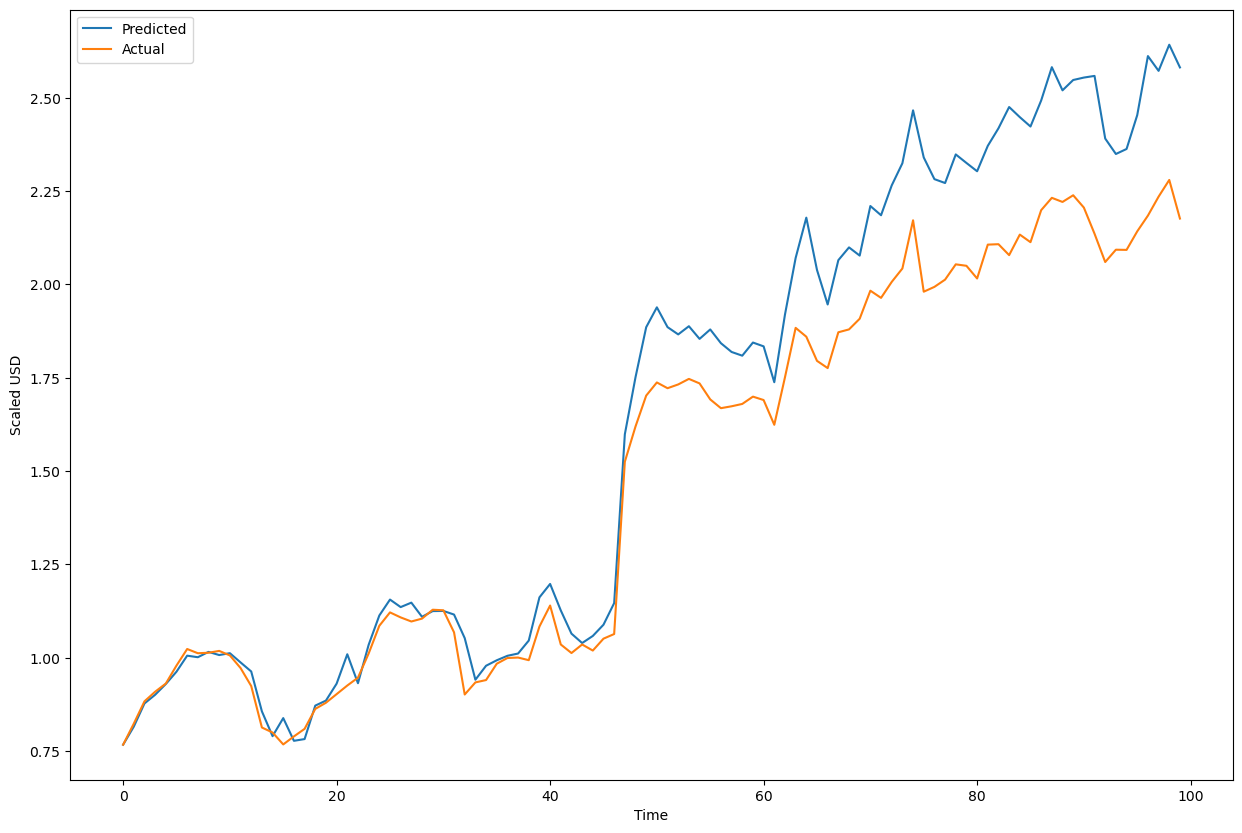

In [68]:
smci_lstm1, smci_y_pred1, smci_y_test1 = predict_using_lstm(smci_data)
plot_predicted_vs_actual (smci_y_pred1, smci_y_test1)

Test RMSE: 377.523
Test MAPE: 0.366


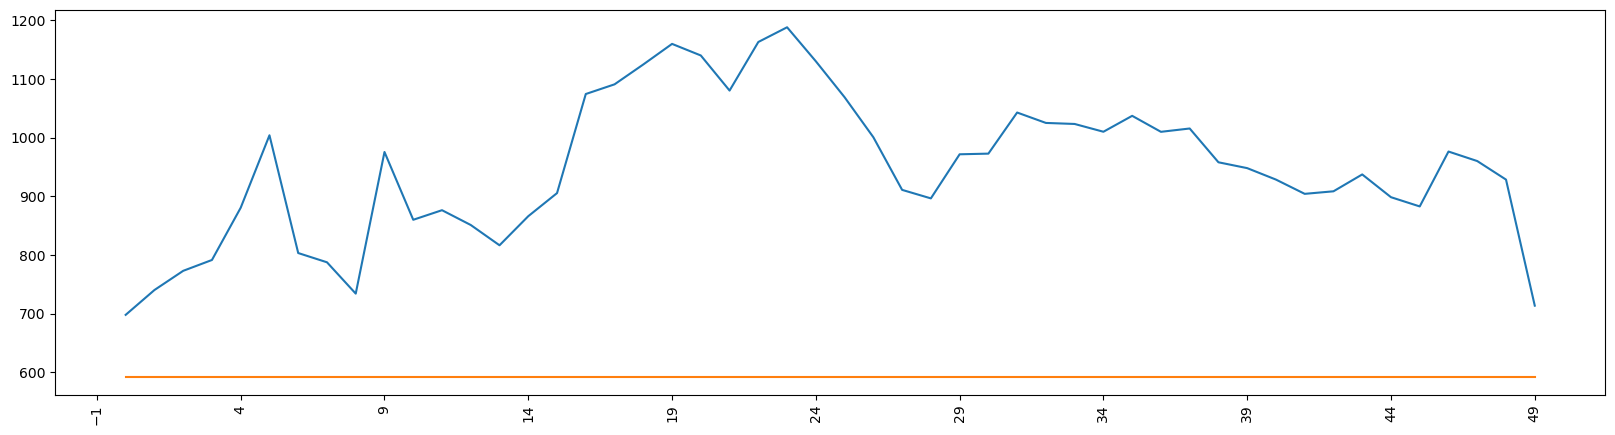

In [69]:
predict_using_ema (smci_data)

Test RMSE: 399.964
Test MAPE: 0.391


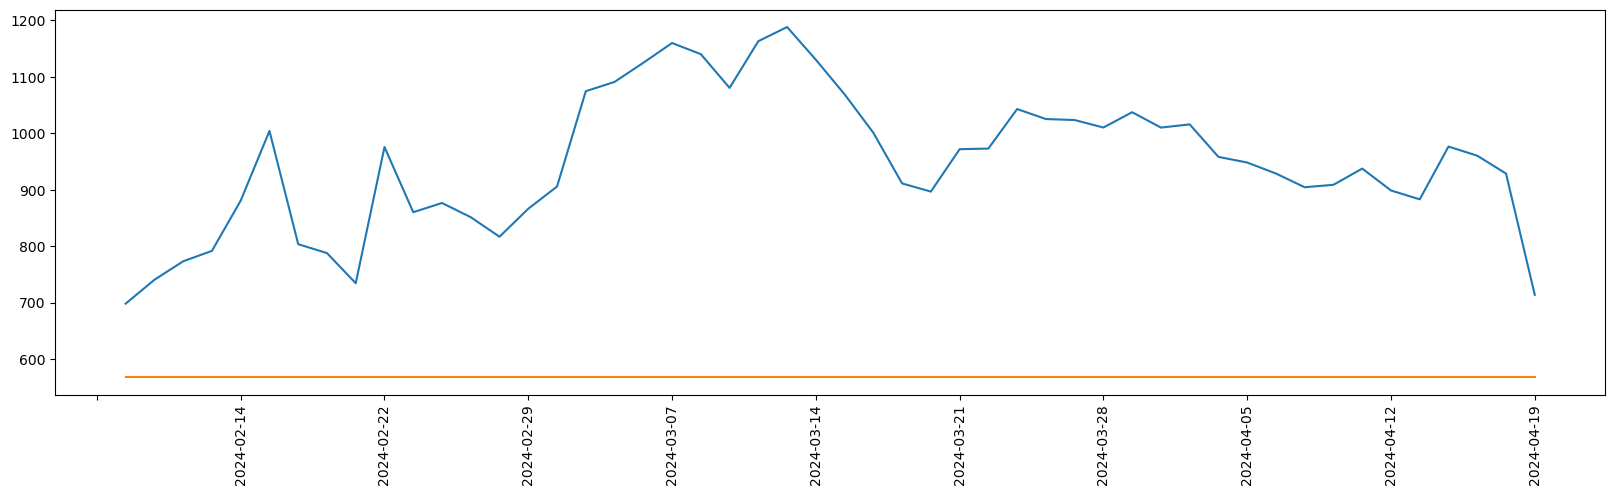

In [70]:
predict_using_sma (smci_data)

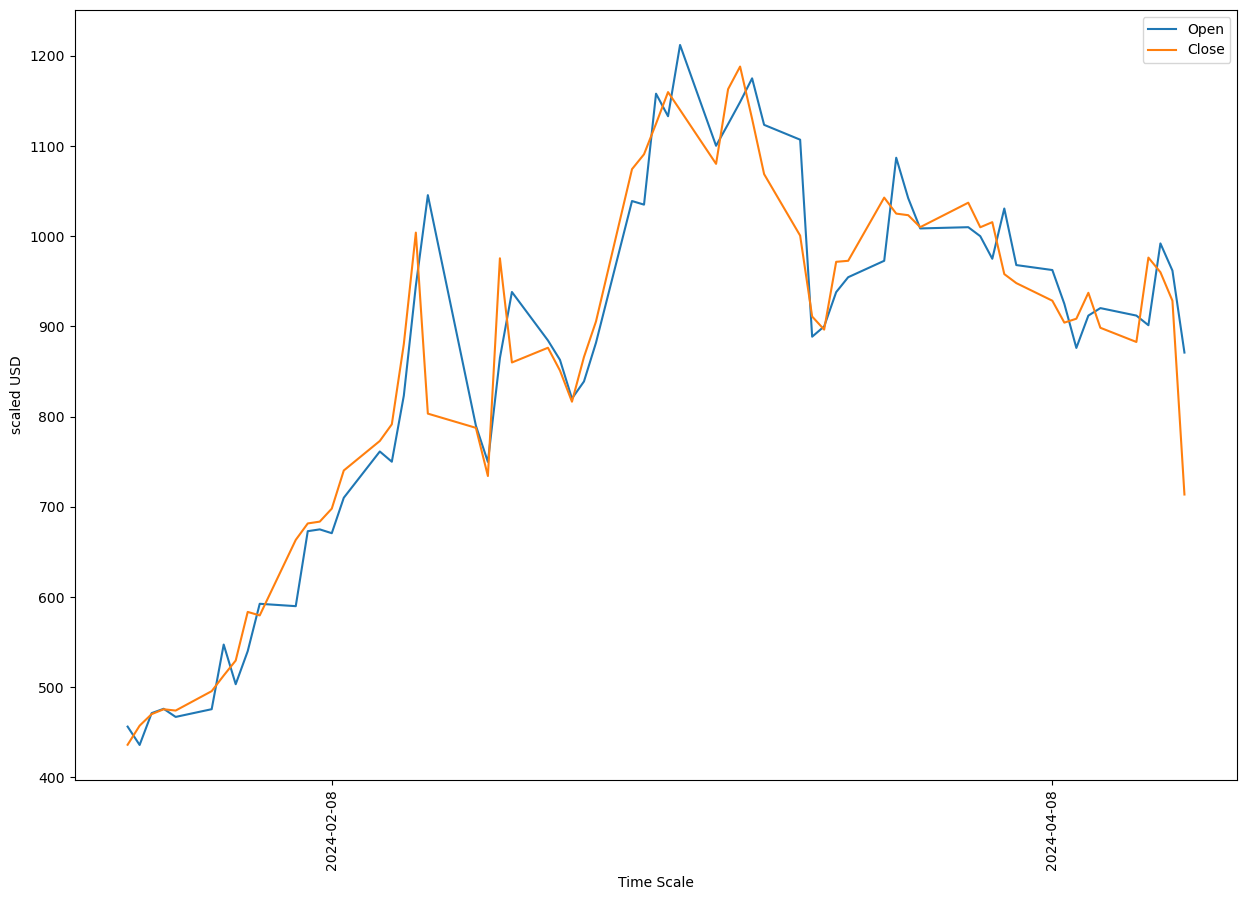

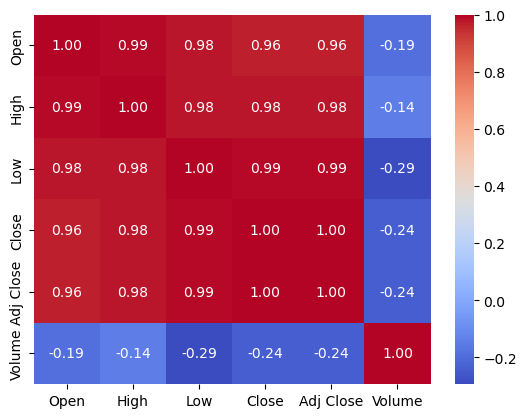

Actual feature data shape  : (500, 2, 2)
Actual target data shape   : (500,)
Training feature data shape: (400, 2, 2)
Training target data shape : (400,)
Testing feature data shape : (100, 2, 2)
Testing target data shape  : (100,)
LSTM Summary: 


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
100/100 - 2s - 24ms/step - loss: 0.4608
Epoch 2/50
100/100 - 0s - 3ms/step - loss: 0.1201
Epoch 3/50
100/100 - 0s - 3ms/step - loss: 0.0056
Epoch 4/50
100/100 - 0s - 3ms/step - loss: 0.0033
Epoch 5/50
100/100 - 0s - 3ms/step - loss: 0.0031
Epoch 6/50
100/100 - 0s - 4ms/step - loss: 0.0028
Epoch 7/50
100/100 - 0s - 4ms/step - loss: 0.0027
Epoch 8/50
100/100 - 0s - 2ms/step - loss: 0.0026
Epoch 9/50
100/100 - 0s - 2ms/step - loss: 0.0026
Epoch 10/50
100/100 - 0s - 3ms/step - loss: 0.0025
Epoch 11/50
100/100 - 0s - 4ms/step - loss: 0.0024
Epoch 12/50
100/100 - 0s - 3ms/step - loss: 0.0023
Epoch 13/50
100/100 - 0s - 2ms/step - loss: 0.0022
Epoch 14/50
100/100 - 0s - 4ms/step - loss: 0.0022
Epoch 15/50
100/100 - 0s - 3ms/step - loss: 0.0021
Epoch 16/50
100/100 - 0s - 3ms/step - loss: 0.0020
Epoch 17/50
100/100 - 0s - 4ms/step - loss: 0.0020
Epoch 18/50
100/100 - 0s - 3ms/step - loss: 0.0020
Epoch 19/50
100/100 - 0s - 3ms/step - loss: 0.0019
Epoch 20/50
100/100 - 0s - 3ms/ste

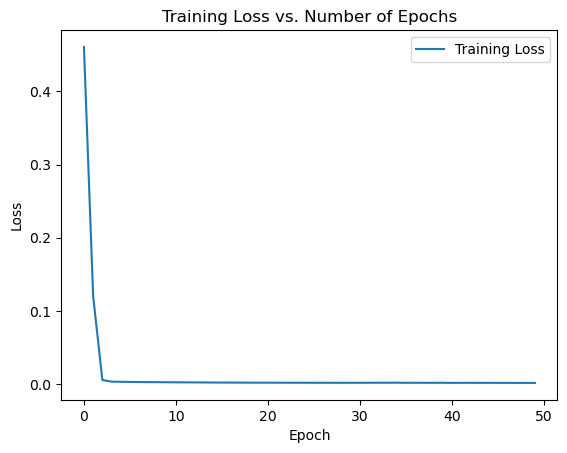

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
RSME : 0.21263770995836645
MAPE : 0.08602112668042365


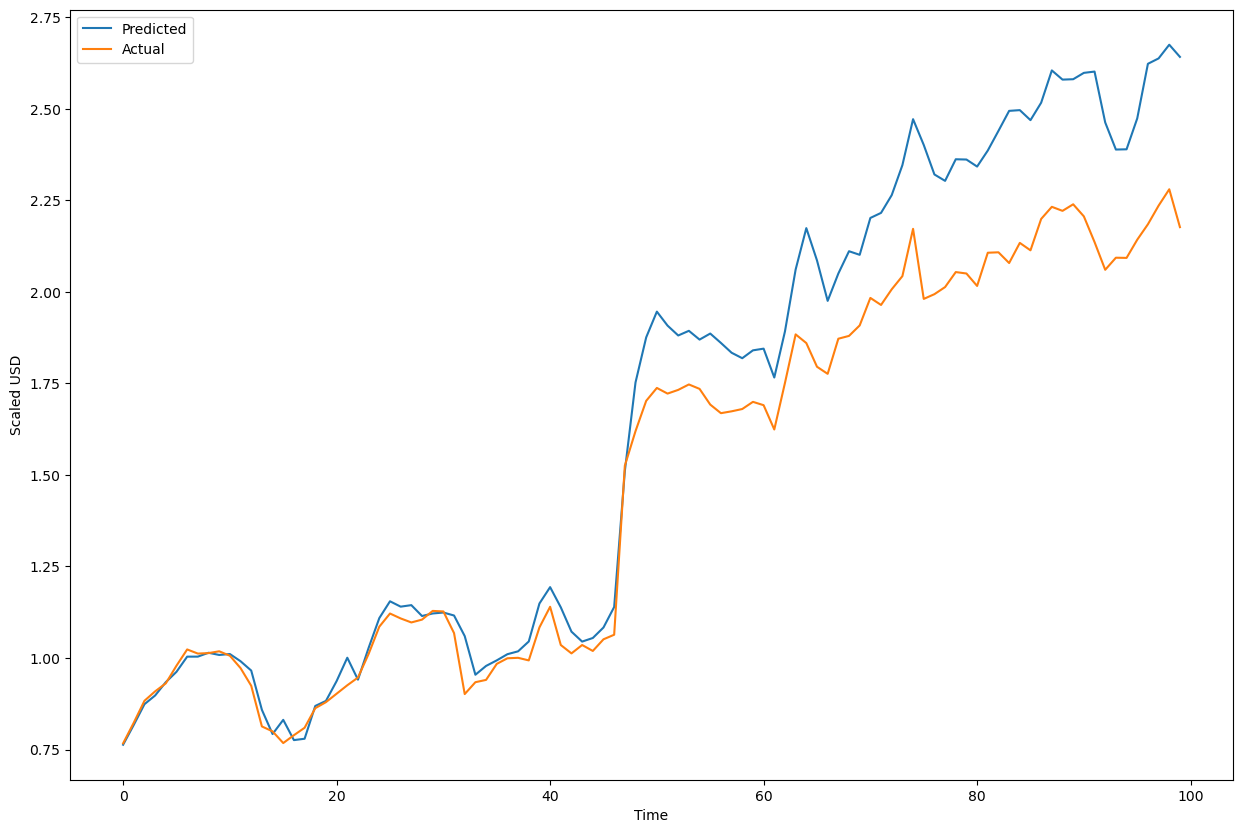

Test RMSE: 122.861
Test MAPE: 0.121


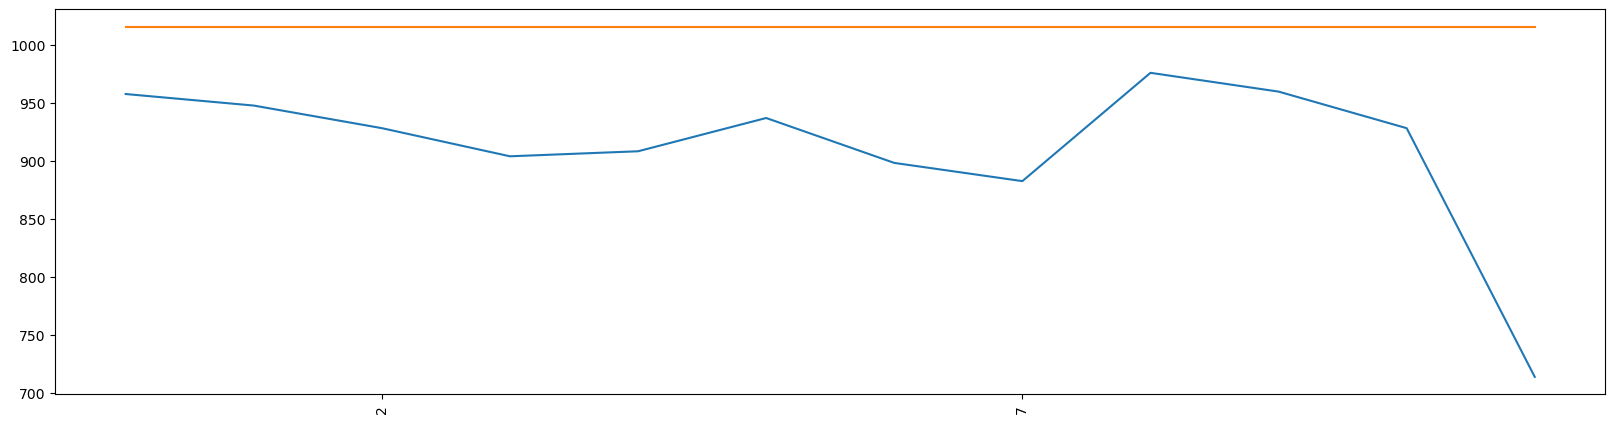

Test RMSE: 110.058
Test MAPE: 0.104


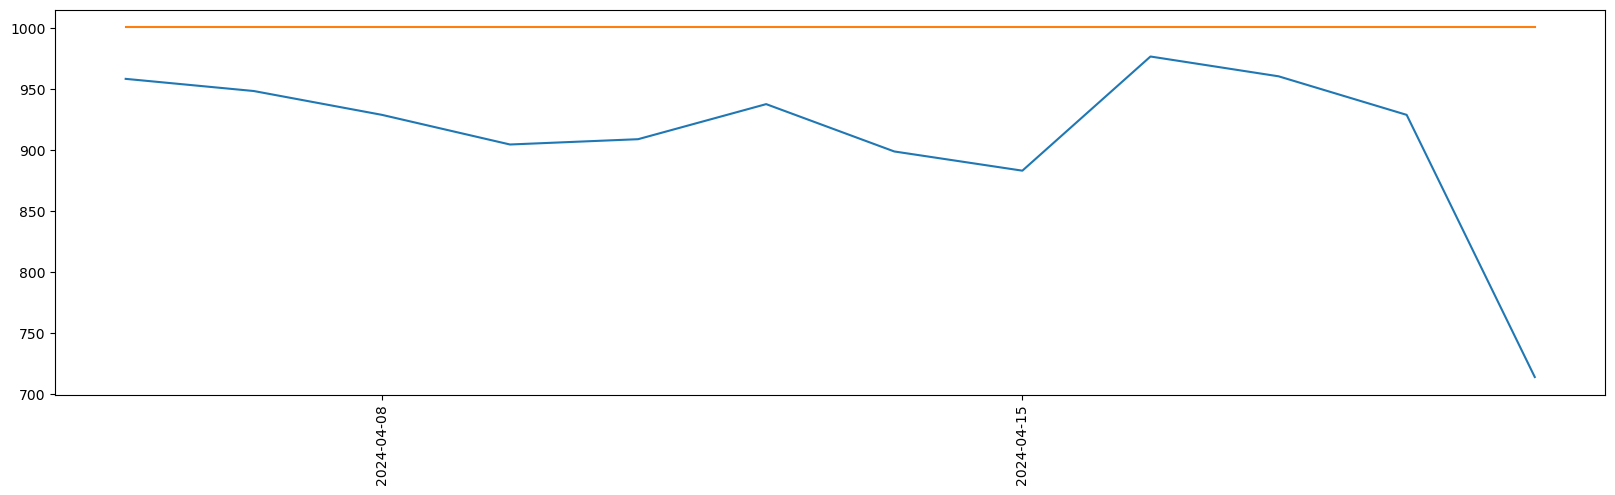

In [71]:
smci_3m_data = pd.read_csv('./SMCI_3m.csv', index_col='Date')
smci_3m_data.head()

plot_init_graph (smci_3m_data, features = ['Open', 'Close'])

smci_3m_correlation_matrix = smci_3m_data.corr()
sns.heatmap(smci_3m_correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

smci_lstm3, smci_y_pred3, smci_y_test3 = predict_using_lstm(smci_3m_data)
plot_predicted_vs_actual (smci_y_pred3, smci_y_test3)

predict_using_ema (smci_3m_data)

predict_using_sma (smci_3m_data)